# Soccer Mobile
<!-- Introduction of the project -->

In [1]:
!pip install --upgrade tdmclient

## Introduction

In this project the goal is to combine vision, path planning, local navigation, and filtering in order to make Thymio robot navigate trough a map towards a goal.  

As the constraints are established we were free to chose our own implementation. To begin with, a camera is used in order to provide the vision information. The vision module works along with the global path and filter modules extracting estimating and computing the necessary map information, including the robot pose, robot pose, map, static obstacles, and the goal position. 

Indeed, a Kalman filter performs the estimations of the robot pose. Afterwards, the A* algorithm computes the optimal path. Following this, a global controller gives instructions to the motors for them to follow the optimal path. Finally, a local navigation module is implemented in order to provide a vision-free information to Thymio for the most spontaneous events such as a dynamic obstacle.

**Imports**

In [2]:
import time
import numpy as np

from geo import *
import filtering

In [3]:
import tdmclient.notebook
await tdmclient.notebook.start()

## Local Navigation


The local navigation module allows to take advantage of the proximity sensors located on the five front horizontal proximity sensors. The objective is to bypass the unknown local obstacle for further re-computing of the controller to correct Thymio's speed.

- **Input**

    - Horizontal proximity sensor values


- **Output**

    - Motion control command for robot translation and rotation

**Parameters**

| Name                | Meaning                                                      | Type (Unit) | Global |
| :------------------- | :------------------------------------------------------------ | :----------- | :------ |
| `max_speed`        |  Nominal speed                 | Int         |  |
| `obstThrL`      | Low obstacle threshold to switch state 1->0                | Int         |    |
| `obstThrH` | High obstacle threshold to switch state 0->1                    | Int         |   |
| `obstSpeedGain`         | Variation of speed according to the distance of obstacle | Int |   |
| `state`         | 0=global navigation, 1=local navigation | Bool |   |
| `obst`         | Measurements from left and right prox sensors | Int |   |


**Functions**

Two functions are basically doing the local avoidance. obs is meant to detect an obstacle and return the new state of the robot as stated in the parameters tabular. obstacle_avoidance updates the new speed to return to thymio. It will return the inputs to the motors function. 

In [4]:
max_speed = 100       # nominal speed
speedGain = 2      # gain used with ground gradient
obstThrL = 10      # low obstacle threshold to switch state 1->0
obstThrH = 20      # high obstacle threshold to switch state 0->1
obstSpeedGain = 5  # /100 (actual gain: 5/100=0.05)

In [5]:
@tdmclient.notebook.sync_var
def motors(left, right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var   
def encoders():
    global motor_left_speed, motor_right_speed
    speed = []
    while len(speed) < 2 :
        speed = [motor_left_speed, motor_right_speed]
    return speed

@tdmclient.notebook.sync_var
def obs():
    global prox_horizontal, state, obst, obstThrH, obstThrL
    obst = [prox_horizontal[0], prox_horizontal[4]]
    
    # switch from goal tracking to obst avoidance if obstacle detected
    if (obst[0] > obstThrH):
        return True
    elif (obst[1] > obstThrH):
        return True
    else:
        return False
    
@tdmclient.notebook.sync_var
def obstacle_avoidance():
    global prox_horizontal, state, obst, obstSpeedGain, speed0, speedGain 
    obst = [prox_horizontal[0], prox_horizontal[4]]
    
    # obstacle avoidance: accelerate wheel near obstacle
    left_speed = max_speed + obstSpeedGain * (obst[0] // 100)
    right_speed = max_speed + obstSpeedGain * (obst[1] // 100)
    motors(left_speed, right_speed)

## Filtering
tell where Thymio is.

## Motion Control

The motion control of Thymio is where all movement functions and interations function with thymio are written. They alllow to update the thymio's movment based on the information returned by the global planing.

## Main : the soccer player

In [6]:
pre_state = np.array([0.0, 0.0, 0]).reshape(-1, 1) # initial state
pre_cov = np.ones([3, 3]) * 0.03 # initial covariance
G_filter = filtering.KF(pre_state, pre_cov, qx=0.1, qy=0.1, qtheta=0.3, rl=0.1, rr=0.1, b=0.0927)
G_filter.timer = time.time()

In [7]:
G_verbose = True
S_camera_interval = 1000 #ms
S_motion_interval = 200 #ms
S_track_interval = 0.2 #s

S_epsilon_dis = 0.005
S_epsilon_theta = 0.1


In [22]:
class MotionController_JN:
    def __init__(self, time_interval = 10, # s 
                 eps_delta_r = 0.005, eps_delta_theta = 0.1,
                 max_speed = 100, 
                 speed_scale = 0.000315, # (m/s) / speed_in_motor_command; 0.000315 for speed<200; 0.0003 for speed \in (200,400)
                 rotate_scale = 0.05, # TODO (rad/s) / speed_in_motor_command
                 obstSpeedGain = 5,  # /100 (actual gain: 5/100=0.05)
                 verbose = False
                 ):
        """Motion Controller

        Connected with thymio interface
        Interface between high-level command and Thymio motion
        """
        self.interval = time_interval   # s, control frequency
        self.timer = time.time()
        self.displacement = [0, 0]
        self.speed = [0, 0]
        
        self.eps_delta_r = eps_delta_r
        self.eps_delta_theta = eps_delta_theta

        self.max_speed = max_speed
        self.speed_scale = speed_scale
        self.rotate_scale = rotate_scale
        self.obstSpeedGain = obstSpeedGain

        self.verbose = verbose

    # -- Local Navigation --
    def avoid(self):
        obstacle_avoidance()

    # -- Path Tracking --        
    def path_tracking(self, waypoint, Thymio_state, theta_track = False):
        """Follow the path

        @return: waypoint reached
        """
        # 4 Track the waypoints
        # 4.1 Are we close enough to the next waypoint?  
        delta_r = Thymio_state.dis(waypoint)
        if delta_r < self.eps_delta_r:
            if self.verbose:
                print("Close to the point")
            # check the rotation
            delta_theta = Thymio_state.delta_theta(waypoint)
            if not theta_track or abs(delta_theta) < self.eps_delta_theta:
                if self.verbose:
                    print(Thymio_state,"Point Finished")
                return True
            else:
                self.rotate(delta_theta) #PULSE
        else:
            # 4.2 Go to the next waypoint
            headto_theta = Thymio_state.headto(waypoint)
            delta_theta = headto_theta - Thymio_state.ori
            delta_theta = Pos.projectin2pi(delta_theta)
            if self.verbose:
                print(F"headto_theta: {headto_theta}")
            if abs(delta_theta) > self.eps_delta_theta:#1.0:
                self.rotate(delta_theta)
            # elif abs(delta_theta) > self.eps_delta_theta:
            #     self.approach(delta_r, delta_theta)
            else:
                self.approach(delta_r, 0)
            return False

    # -- Movement --
    def approach(self, delta_r, delta_theta = 0):
        """approach to the goal point
        
            move with modification of direction
        """
        if self.verbose:
            print(F"approach to dr:{delta_r}, dt:{delta_theta}")
        # assume u only move <interval> s. 
        advance_speed = min(delta_r/self.interval/self.speed_scale * 50 + 20, self.max_speed)
        delta_speed = delta_theta/self.interval/self.rotate_scale
        if delta_speed > 0:
            delta_speed = min(delta_speed, self.max_speed/2)
            self.move(min(advance_speed, self.max_speed - 2*abs(delta_speed)), delta_speed)
        else:
            delta_speed = max(delta_speed, -self.max_speed/2)
            self.move(min(advance_speed, self.max_speed - 2*abs(delta_speed)), delta_speed)

    def rotate(self, delta_theta):
        """rotate in place
        """
        if self.verbose:
            print(F"rotate to dt:{delta_theta}")
        delta_speed = delta_theta/(self.interval)/self.rotate_scale
        if delta_speed > 0:
            self.move(0, min(delta_speed + 10, self.max_speed))
        else:
            self.move(0, max(delta_speed - 10, -self.max_speed))

    def move(self, vel, omega = 0):
        """
        move with transitional velocity and rotational velocity
        """
        if self.verbose:
            print(F"move with {vel}, {omega}")
        self._set_motor(vel - omega, vel + omega)

    def stop(self):
        """Stop both motors
        """
        self._set_motor(0, 0)

    def update_displacement(self):
        starter = time.time()
        interval = starter - self.timer
        self.timer = starter
        rls, rrs = encoders()
        # rls = int(rls * float(os.getenv("OFFSET_WHEELS")))
        rls = rls if rls < 2 ** 15 else rls - 2 ** 16
        rrs = rrs if rrs < 2 ** 15 else rrs - 2 ** 16
        rls = 0 if abs(rls) > self.max_speed * 1.1 else rls
        rrs = 0 if abs(rrs) > self.max_speed * 1.1 else rrs 
        self.displacement[0] += rls*interval*self.speed_scale
        self.displacement[1] += rrs*interval*self.speed_scale

    def _set_motor(self, ls, rs):
        ls = (int)(ls)
        rs = (int)(rs)
        # l_speed = int(ls / float(os.getenv("OFFSET_WHEELS")))
        l_speed = ls if ls >= 0 else 2 ** 16 + ls
        r_speed = rs if rs >= 0 else 2 ** 16 + rs           
        self.update_displacement()
        motors(l_speed, r_speed)

    def get_displacement(self):
        self.update_displacement()
        ret = self.displacement
        self.displacement = [0, 0]
        # if self.verbose:
        #     print(F"Displacement:{ret}")
        return ret

    # -- Sensor --
    def obs_front(self):
        """if there's obstacle on the way forward"""
        return obs()

    def acc(self):
        pass
    
G_mc = MotionController_JN(verbose = True, time_interval = S_motion_interval/1000.0 )
print(S_motion_interval)
print(G_mc.interval)

200
0.2


In this main all the motion control and local avoidance functions are called in a while loop. This merges all the modules and communicates with the thymio thanks to the motion contol module.

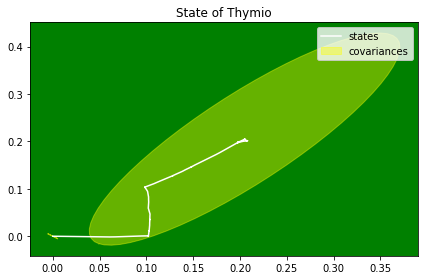

(0.1979696818292917, 0.19780219961461035, 6.153693449646272)


In [23]:
G_track_timer = time.time()
G_mc.get_displacement()

def localizate():
    """Track Where Thymio is"""
    global G_camera_timer
    starter = G_filter.timer
    # 3. Localization 
    # 3.1 odometer
    dsl, dsr = G_mc.get_displacement()
    # 3.2 With Vision
        # if starter - G_camera_timer > S_camera_interval:
        #     vision_thymio_state = G_vision._getThymio()
        #     # Vision Failed
        #     if vision_thymio_state is None:
        #         G_filter.kalman_filter(dsr, dsl)
        #     else:
        #         G_camera_timer = starter
        #         G_filter.kalman_filter(dsr, dsl, vision_thymio_state)
        # else:        
        #     G_filter.kalman_filter(dsr, dsl)
    G_filter.kalman_filter(dsr, dsl)
    G_filter.plot_gaussian()
    thymio_state = G_filter.get_state()
    return thymio_state

print(localizate())

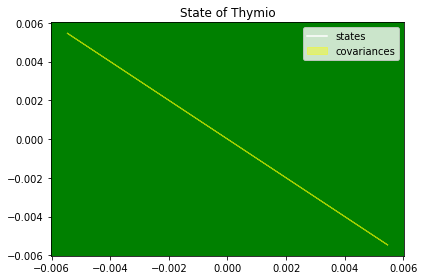

(0.0, 0.0, 0.0)


In [29]:
def reset():
    G_filter.states = [np.array([0.0, 0.0, 0]).reshape(-1, 1)] # initial state
    G_filter.covs = [np.ones([3, 3]) * 0.03]    
    G_track_timer = time.time()
    G_mc.get_displacement()
    print(localizate())
   
reset() 
## Fake Waypoints
Global_path = [State(Pos(0.1,0.0),0), State(Pos(0.1, 0.1),0.0),State(Pos(0.15, 0.15),0.0), State(Pos(0.2,0.2),0)]
Goal_state = Global_path[-1]

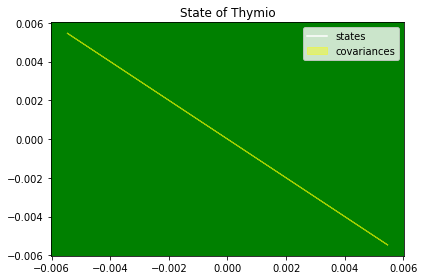

headto_theta: 0.0
approach to dr:0.1, dt:0
move with 100, 0.0
thymio: (0.0, 0.0, 0.0)


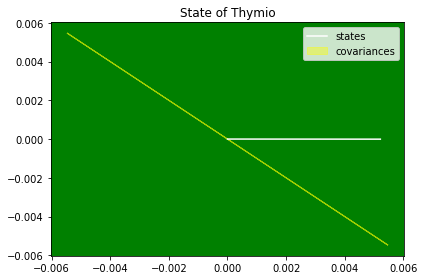

headto_theta: 5.9133203479781e-05
approach to dr:0.09478546696118245, dt:0
move with 100, 0.0
thymio: (0.005214533204537421, -5.6049683014751455e-06, 6.281035559187561)


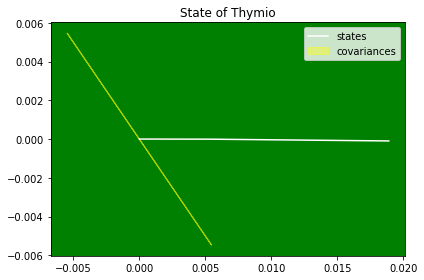

headto_theta: 0.0012010921034824244
approach to dr:0.08110139490430686, dt:0
move with 100, 0.0
thymio: (0.018898663595024144, -9.741022157994339e-05, 6.271917487034266)


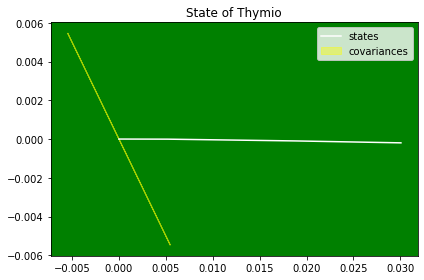

headto_theta: 0.0027976808868016576
approach to dr:0.06993622796195102, dt:0
move with 100, 0.0
thymio: (0.030064045733940066, -0.00019565899302616634, 6.276854762207861)


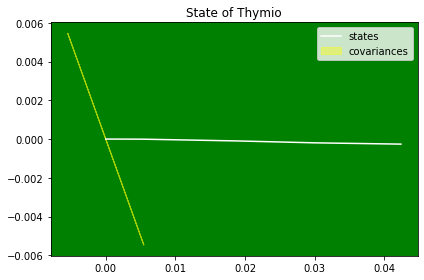

thymio: (0.042368331603296214, -0.00026157321122613627, 6.2788019288266534)


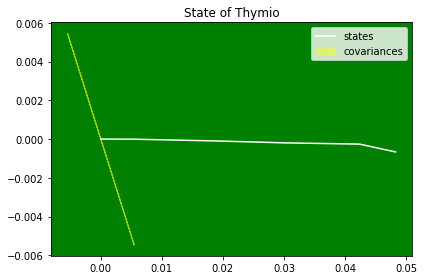

thymio: (0.04827119903466318, -0.000664826850397293, 6.151150893040978)


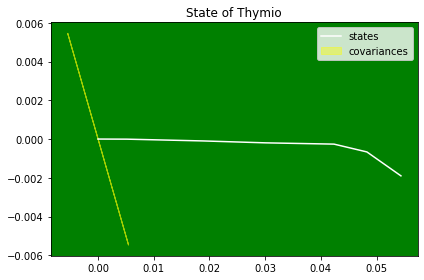

headto_theta: 0.04161110328757609
rotate to dt:0.3081697896782396
move with 0, 40.81697896782396
thymio: (0.054382980060733305, -0.001899270840558332, 6.016626620788923)


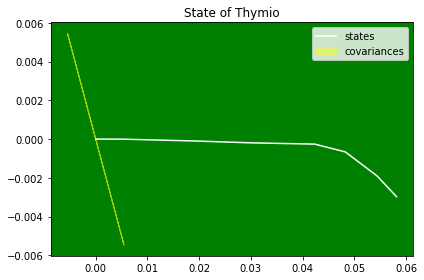

headto_theta: 0.07088167879600366
rotate to dt:0.3581633108721922
move with 0, 45.81633108721922
thymio: (0.05815403282327803, -0.0029710898672632106, 5.995903675103397)


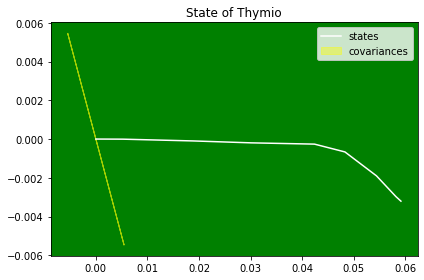

headto_theta: 0.07823758492950268
rotate to dt:0.26574092614598754
move with 0, 36.574092614598754
thymio: (0.05912026242561363, -0.003204873748994039, 6.095681965963101)


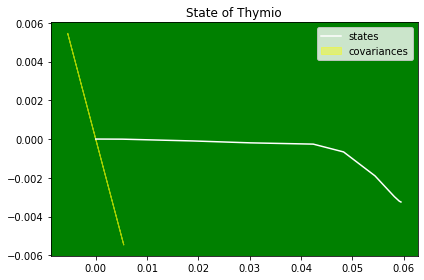

headto_theta: 0.07991731879502842
rotate to dt:0.16800700444341832
move with 0, 26.80070044434183
thymio: (0.05943612118603961, -0.0032486755710608925, 6.1950956215311965)


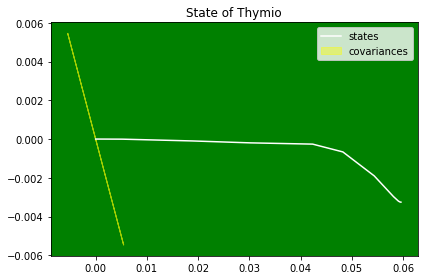

headto_theta: 0.08044307245467132
approach to dr:0.04052763686304447, dt:0
move with 100, 0.0
thymio: (0.059603421390340076, -0.0032566526275251873, 6.275984978246204)


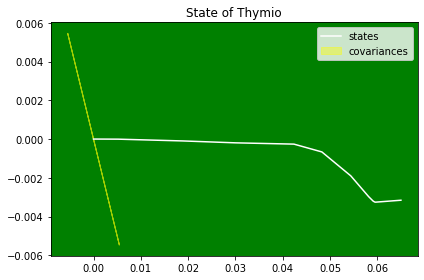

headto_theta: 0.08989582607431076
approach to dr:0.035161402372522674, dt:0
move with 100, 0.0
thymio: (0.06498057618431315, -0.003156607739290265, 0.04440712338512398)


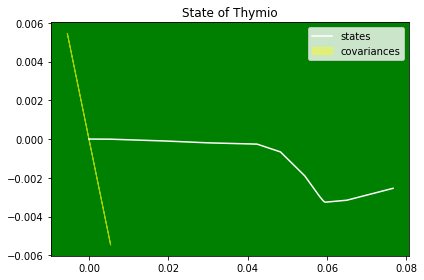

headto_theta: 0.10838435831062267
approach to dr:0.023503790141191756, dt:0
move with 100, 0.0
thymio: (0.07663412626780655, -0.0025424585999332837, 0.060896670008168785)


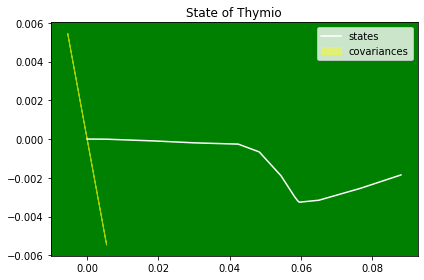

headto_theta: 0.15300123969409052
approach to dr:0.0121509001036911, dt:0
move with 100, 0.0
thymio: (0.0879910451826183, -0.001851857857386766, 0.060571382578137)


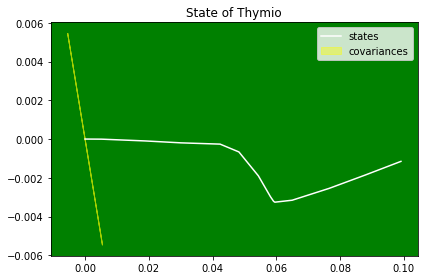

Close to the point
(0.09910922672961245, -0.0011521998203784098, 0.06512123265312726) Point Finished
(0.1, 0.0, 0) reached
thymio: (0.09910922672961245, -0.0011521998203784098, 0.06512123265312726)


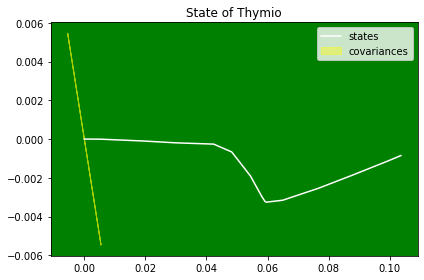

headto_theta: 1.6074504095777369
rotate to dt:1.5413467863634596
move with 0, 100
thymio: (0.10369824519273857, -0.0008506703591041938, 0.06610362321427737)


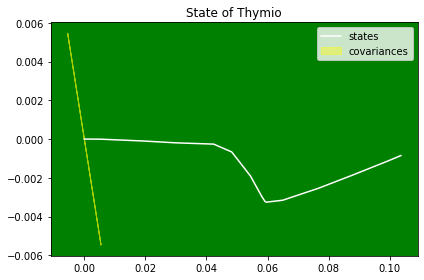

headto_theta: 1.6074504095777369
rotate to dt:1.4361877872352105
move with 0, 100
thymio: (0.10369824519273857, -0.0008506703591041938, 0.17126262234252645)


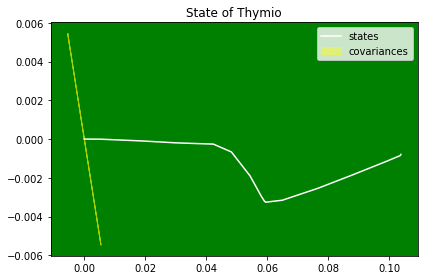

headto_theta: 1.6094972908417806
rotate to dt:1.1957043296424739
move with 0, 100
thymio: (0.10390258506697798, -0.0007891297763496981, 0.41379296119930686)


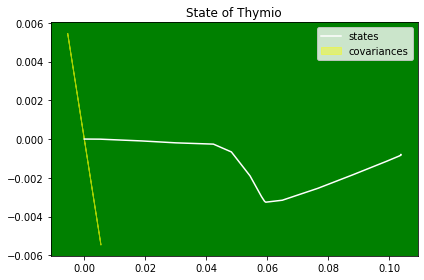

headto_theta: 1.6089134697018845
rotate to dt:0.956431157073518
move with 0, 100
thymio: (0.10384495238972546, -0.0008231410998896782, 0.6524823126283665)


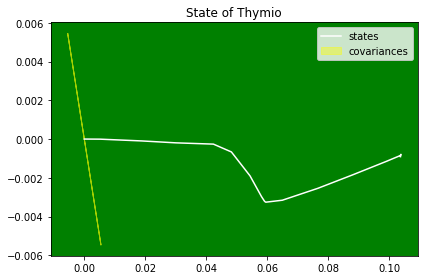

headto_theta: 1.6080098960651033
rotate to dt:0.7164426097079643
move with 0, 81.64426097079641
thymio: (0.10375691313599712, -0.0009088565304569797, 0.891567286357139)


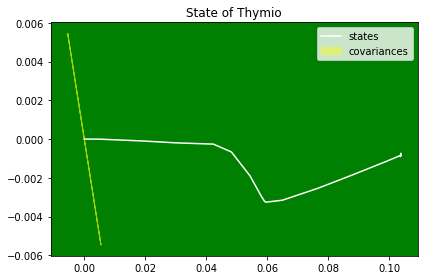

headto_theta: 1.609122913607582
rotate to dt:0.501204796838995
move with 0, 60.12047968389949
thymio: (0.10386305189761401, -0.000743648714409461, 1.107918116768587)


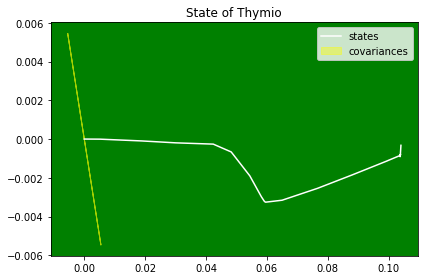

headto_theta: 1.6109027478482163
rotate to dt:0.31540032002025153
move with 0, 41.54003200202516
thymio: (0.10402575603678794, -0.00032302035076748166, 1.2955024278279648)


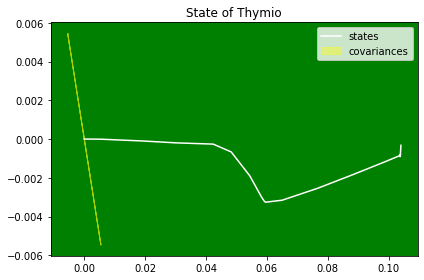

headto_theta: 1.6109038358077128
rotate to dt:0.19326290082189446
move with 0, 29.326290082189445
thymio: (0.10402584833561175, -0.0003225961112832101, 1.4176409349858183)


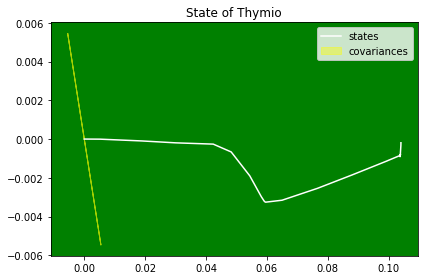

headto_theta: 1.6111054535388833
rotate to dt:0.11409782394528412
move with 0, 21.409782394528413
thymio: (0.10404081218422008, -0.00019129003398438496, 1.4970076295935992)


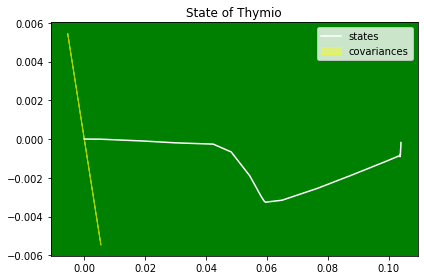

headto_theta: 1.6111131823364337
approach to dr:0.10026362576525892, dt:0
move with 100, 0.0
thymio: (0.10404121910924737, -0.00018215010523055174, 1.5556004178176805)


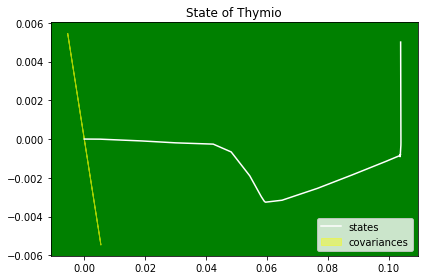

headto_theta: 1.6122942432833065
approach to dr:0.09507742630116389, dt:0
move with 100, 0.0
thymio: (0.10394438278056507, 0.005004427279300891, 1.6233290271851621)


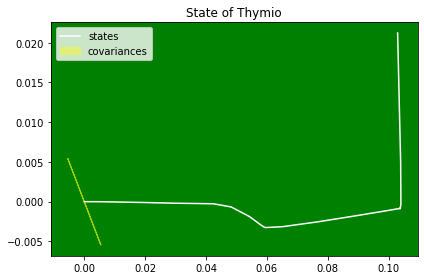

headto_theta: 1.6082830726841844
approach to dr:0.07882871136942199, dt:0
move with 100, 0.0
thymio: (0.10295433982441003, 0.021226669409212213, 1.6401723610544665)


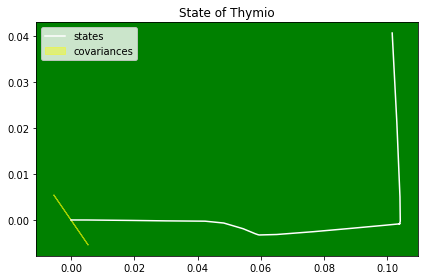

headto_theta: 1.595900322572302
approach to dr:0.0594124465676102, dt:0
move with 100, 0.0
thymio: (0.10149133315391284, 0.04060627362613811, 1.6521186109885426)


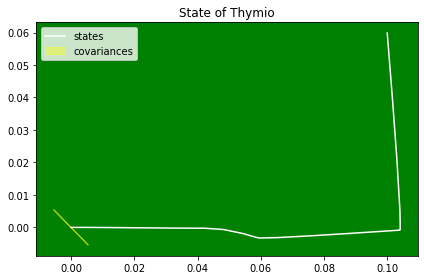

headto_theta: 1.5687851546280256
approach to dr:0.040148871358793935, dt:0
move with 100, 0.0
thymio: (0.09991925376182585, 0.05985120983852684, 1.6524879930088818)


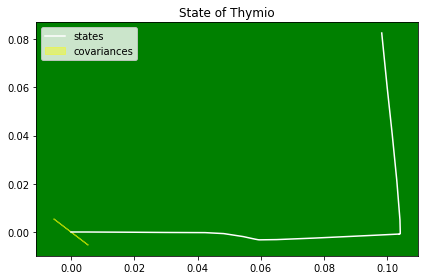

headto_theta: 1.4670247989807677
rotate to dt:-0.17433711303364685
move with 0, -27.433711303364685
thymio: (0.09818567265410134, 0.08257893896652944, 1.6413619120144147)


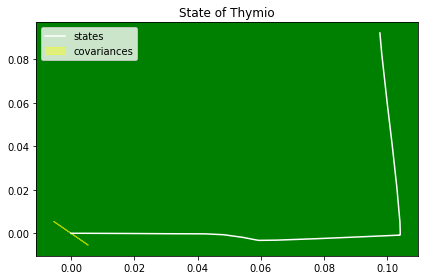

headto_theta: 1.275697429431824
rotate to dt:-0.34543547943094666
move with 0, -44.543547943094666
thymio: (0.09760761730455088, 0.09212965348592014, 1.621132908862771)


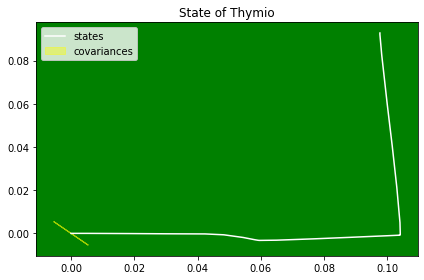

headto_theta: 1.2508286397271025
rotate to dt:-0.2620462937425403
move with 0, -36.204629374254026
thymio: (0.09761011213240423, 0.09278749870004482, 1.5128749334696425)


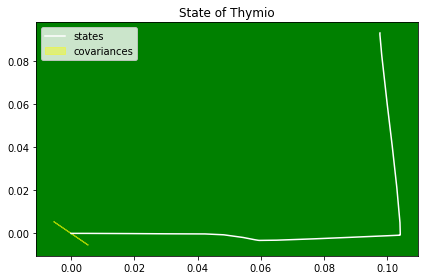

headto_theta: 1.249065765191115
approach to dr:0.0075201015678336295, dt:0
move with 100, 0.0
thymio: (0.09762207771393752, 0.09286575770021924, 1.3252733643772532)


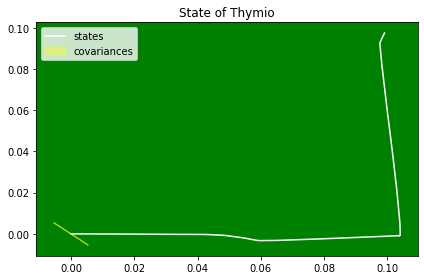

Close to the point
(0.09905624330243731, 0.09748779932313995, 1.2145818856155988) Point Finished
(0.1, 0.1, 0.0) reached
thymio: (0.09905624330243731, 0.09748779932313995, 1.2145818856155988)


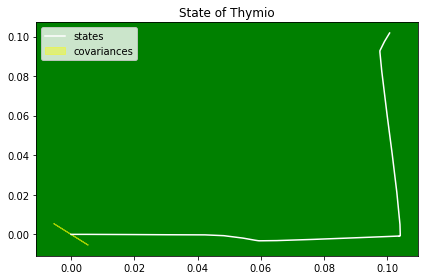

headto_theta: 0.7740884157104464
rotate to dt:-0.43221022167969014
move with 0, -53.22102216796901
thymio: (0.10067173106338262, 0.10177508005931629, 1.2062986373901368)


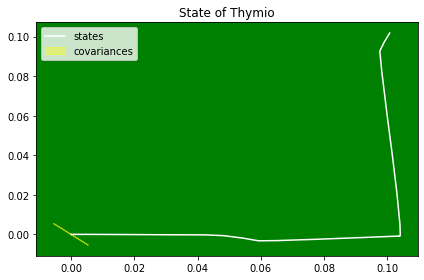

headto_theta: 0.773694940827825
rotate to dt:-0.3760346901887308
move with 0, -47.60346901887308
thymio: (0.10069814125077715, 0.10183882490669398, 1.1497296310165555)


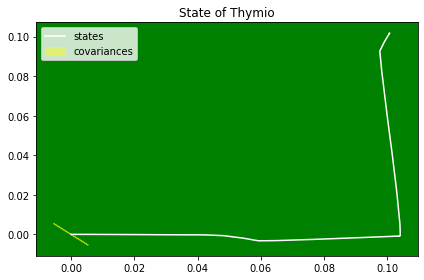

headto_theta: 0.7746201312655239
rotate to dt:-0.23713862930711294
move with 0, -33.713862930711294
thymio: (0.10059855234933525, 0.10165213834318924, 1.0117587605726373)


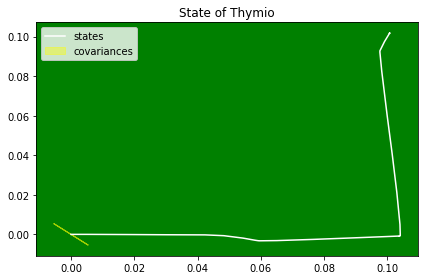

headto_theta: 0.7741933539821163
rotate to dt:-0.11771368926658798
move with 0, -21.7713689266588
thymio: (0.1006954120626956, 0.10178811132699767, 0.8919070432487044)


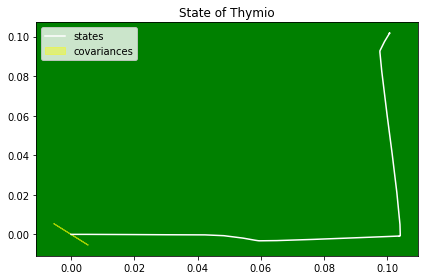

headto_theta: 0.7742321401004432
approach to dr:0.06899363375383126, dt:0
move with 100, 0.0
thymio: (0.10067244219533512, 0.1017619077949257, 0.8102210827244138)


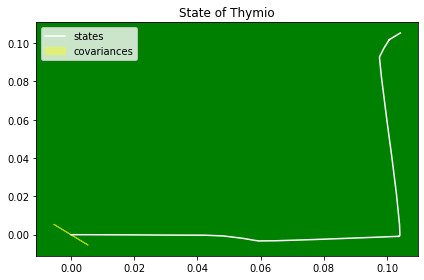

headto_theta: 0.7735593110027897
approach to dr:0.06406749089052806, dt:0
move with 100, 0.0
thymio: (0.104164299708098, 0.10523693522826177, 0.7557438030983638)


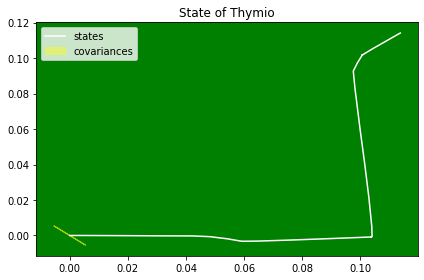

headto_theta: 0.7793413636899214
approach to dr:0.05096492429360151, dt:0
move with 100, 0.0
thymio: (0.11374474599010553, 0.11418128889908843, 0.7464047872904435)


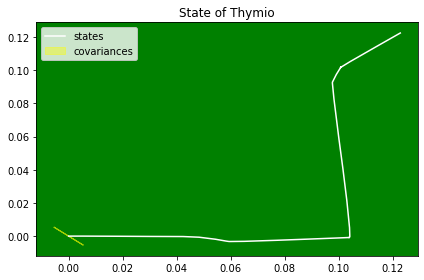

headto_theta: 0.7896138794394004
approach to dr:0.038756011856821676, dt:0
move with 100, 0.0
thymio: (0.1227111345583312, 0.12248007489195152, 0.7470948817660508)


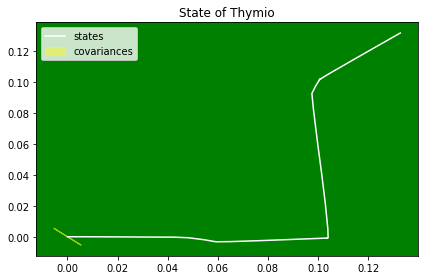

headto_theta: 0.8143587122672028
approach to dr:0.024966568801760285, dt:0
move with 100, 0.0
thymio: (0.13286457165192614, 0.1318421737793023, 0.7426475688091759)


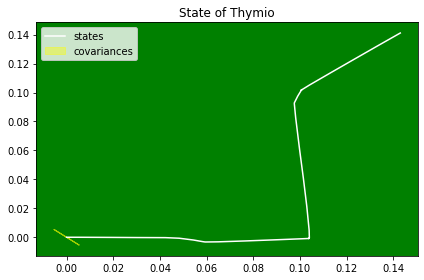

headto_theta: 0.9040149541208596
rotate to dt:0.16558285471833012
move with 0, 26.55828547183301
thymio: (0.14300274346789577, 0.14110927319254635, 0.7384320994025295)


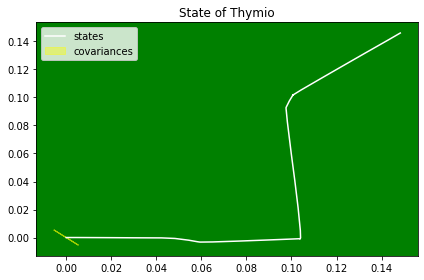

Close to the point
(0.14829159794566463, 0.14603040158607938, 0.7603626950273236) Point Finished
(0.15, 0.15, 0.0) reached
thymio: (0.14829159794566463, 0.14603040158607938, 0.7603626950273236)


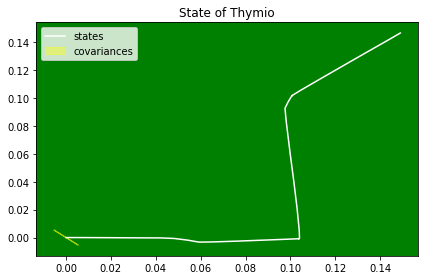

headto_theta: 0.80726457881661
approach to dr:0.07380036095962514, dt:0
move with 100, 0.0
thymio: (0.14896874179986713, 0.14668673744477523, 0.7792275973894063)


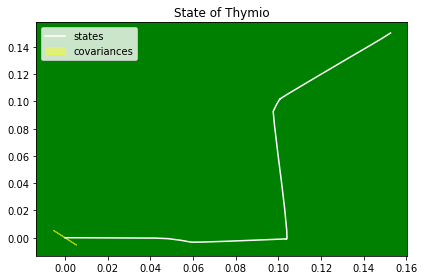

headto_theta: 0.8093060340937344
approach to dr:0.06874666527565212, dt:0
move with 100, 0.0
thymio: (0.15256473926039332, 0.1502405785294073, 0.7797766065134585)


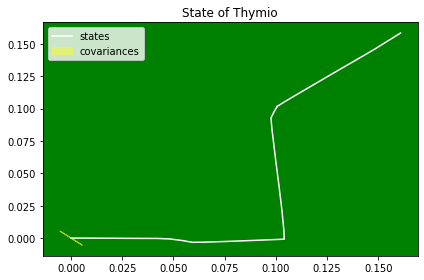

headto_theta: 0.815645180227277
approach to dr:0.0571084561230171, dt:0
move with 100, 0.0
thymio: (0.16085793632563375, 0.15841545224405554, 0.7766499357316099)


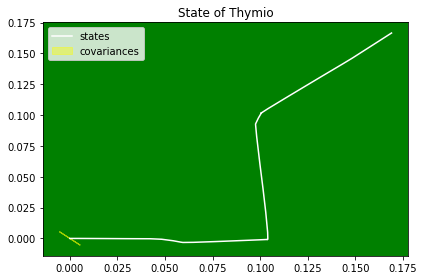

headto_theta: 0.8247557651662342
approach to dr:0.04559966642383742, dt:0
move with 100, 0.0
thymio: (0.16904984896247127, 0.1665124242633271, 0.7824894182890363)


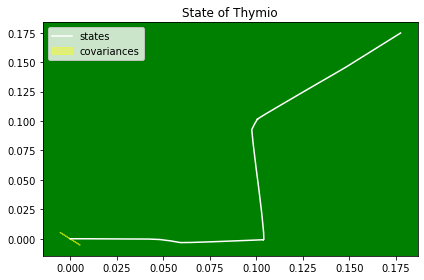

headto_theta: 0.8402928283478854
approach to dr:0.03376976574221028, dt:0
move with 100, 0.0
thymio: (0.17746730128170177, 0.17484697698577448, 0.7784097147219388)


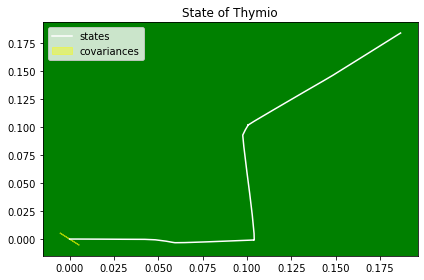

headto_theta: 0.8763982855658502
approach to dr:0.02109278032329613, dt:0
move with 100, 0.0
thymio: (0.18650224501405005, 0.18379148396348108, 0.7823266838360756)


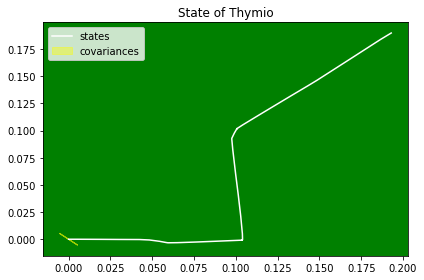

headto_theta: 0.9667466986049635
rotate to dt:0.25211248369910455
move with 0, 35.21124836991045
thymio: (0.19294202264879, 0.18977250564656442, 0.714634214905859)


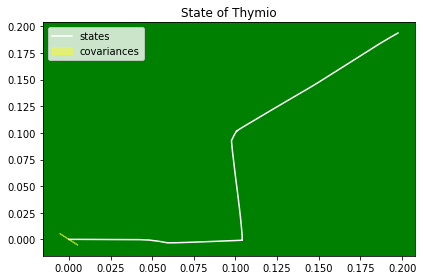

headto_theta: 1.1866513114550912
rotate to dt:0.4472122517624123
move with 0, 54.72122517624123
thymio: (0.197507513470755, 0.1938339433448638, 0.7394390596926789)


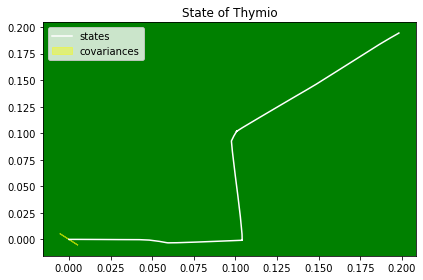

headto_theta: 1.2453635052014265
rotate to dt:0.41291697228070046
move with 0, 51.29169722807004
thymio: (0.19812949143673722, 0.19445659917944083, 0.832446532920726)


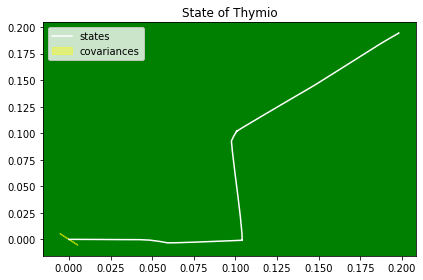

headto_theta: 1.241682248388597
rotate to dt:0.26882385982579293
move with 0, 36.882385982579294
thymio: (0.19808937125951423, 0.19440576507656487, 0.972858388562804)


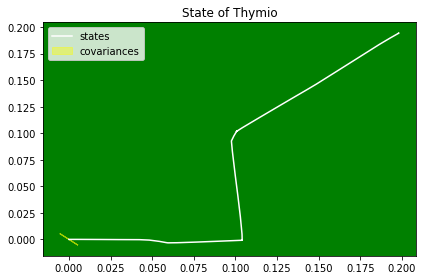

headto_theta: 1.2389405386570809
rotate to dt:0.15906621999256743
move with 0, 25.906621999256743
thymio: (0.19804958288340846, 0.1943400499377768, 1.0798743186645134)


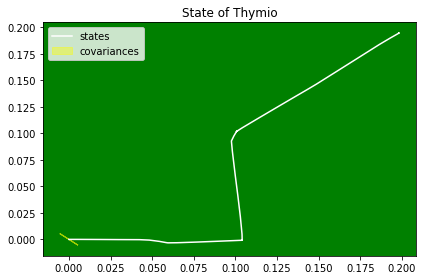

headto_theta: 1.2432324159522983
approach to dr:0.005784321066274629, dt:0
move with 100, 0.0
thymio: (0.19813896743095905, 0.19452323745496328, 1.1538117764065563)


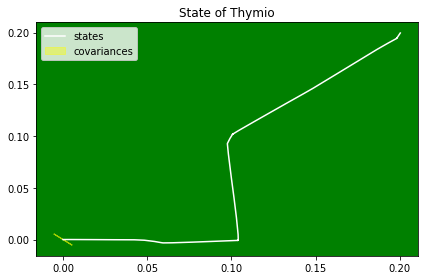

Close to the point
rotate to dt:-1.2055552538158825
move with 0, -100
thymio: (0.20022172995299978, 0.1995741176490437, 1.205555253815882)


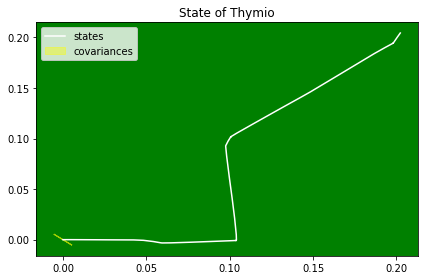

Close to the point
rotate to dt:-1.1193018384350157
move with 0, -100
thymio: (0.20227828748170873, 0.20432705369852003, 1.1193018384350153)


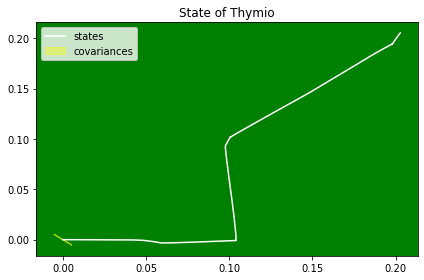

headto_theta: -2.066472753579349
rotate to dt:-2.976009285060119
move with 0, -100
thymio: (0.20274815999382484, 0.20508258011956815, 0.9095365314807704)


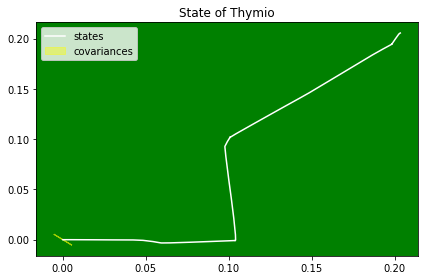

headto_theta: -2.0965746850657325
rotate to dt:-2.767397292957963
move with 0, -100
thymio: (0.20323361506943724, 0.20557269985024237, 0.6708226078922306)


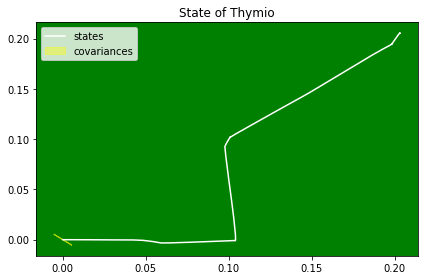

headto_theta: -2.0864811766590563
rotate to dt:-2.5154830771838252
move with 0, -100
thymio: (0.20311905878876751, 0.20550247862689983, 0.4290019005247687)


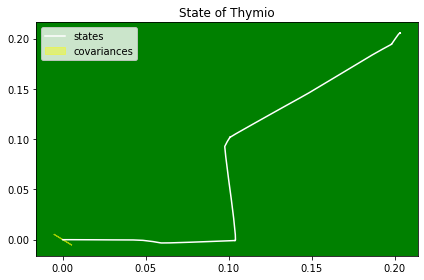

headto_theta: -2.114570156773804
rotate to dt:-2.287865292063524
move with 0, -100
thymio: (0.20337462992379626, 0.20558185777316668, 0.17329513528971968)


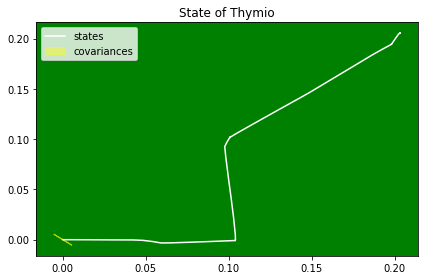

headto_theta: -2.1157220953923983
rotate to dt:-2.0508655639575526
move with 0, -100
thymio: (0.2033837150677906, 0.2055823508465947, 6.21832877574474)


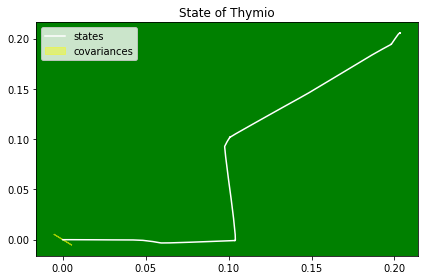

headto_theta: -2.1331844158702653
rotate to dt:-1.8323842348563986
move with 0, -100
thymio: (0.20350438866595807, 0.20556003913663384, 5.9823851261657195)


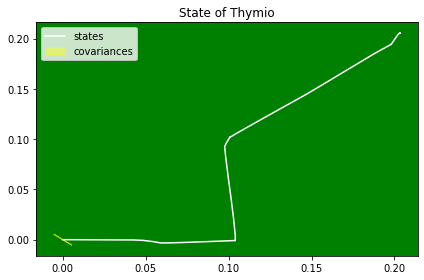

headto_theta: -2.1163692732594344
rotate to dt:-1.5501874730560186
move with 0, -100
thymio: (0.2034034684200713, 0.2056067503831113, 5.71700350697617)


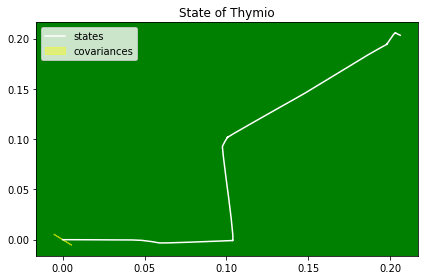

headto_theta: -2.6510935751740643
rotate to dt:-1.902750160353552
move with 0, -100
thymio: (0.20630538447639038, 0.2033672605945537, 5.534841892359073)


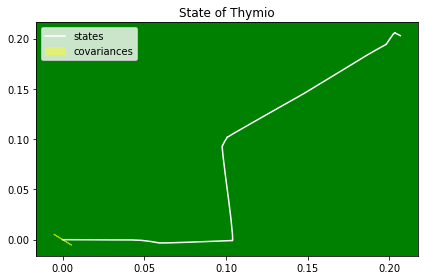

headto_theta: -2.724815072917971
rotate to dt:-1.7321832375360096
move with 0, -100
thymio: (0.20665879764363643, 0.20294793648140855, 5.290553471797625)


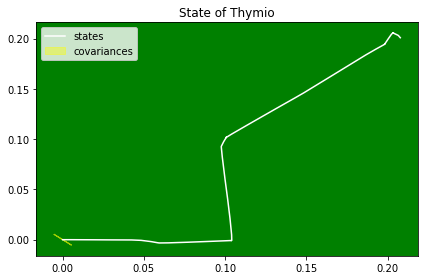

headto_theta: -3.0230074163397713
rotate to dt:-1.8459098763454485
move with 0, -100
thymio: (0.20772941661875133, 0.20092091553476268, 5.106087767185263)


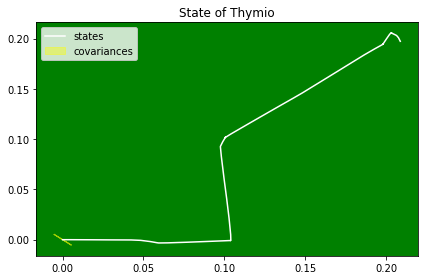

headto_theta: 2.8532149219929424
rotate to dt:-2.0784536822707853
move with 0, -100
thymio: (0.2088518350534013, 0.19737413049971234, 4.931668604263728)


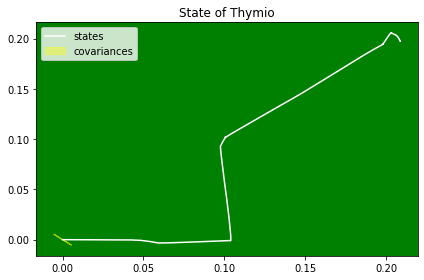

headto_theta: 2.854380649846897
rotate to dt:-1.8440461891723379
move with 0, -100
thymio: (0.2088506425614639, 0.19738570574235742, 4.698426839019235)


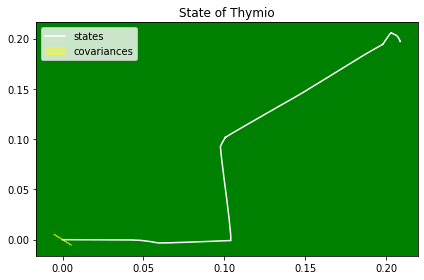

headto_theta: 2.832335447361713
rotate to dt:-1.6183395596491597
move with 0, -100
thymio: (0.20882227490239497, 0.1971812065196261, 4.450675007010873)


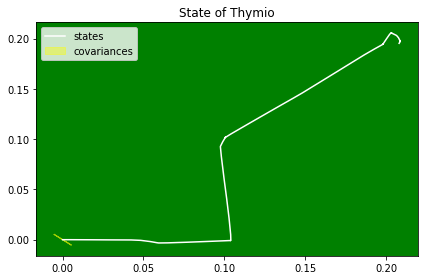

headto_theta: 2.6246065937005456
rotate to dt:-1.6234691136618942
move with 0, -100
thymio: (0.20813588971340533, 0.19537420386178064, 4.24807570736244)


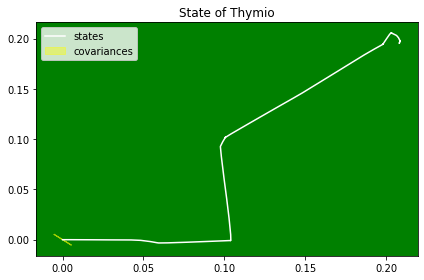

headto_theta: 2.6258221182354236
rotate to dt:-1.3912561985882732
move with 0, -100
thymio: (0.2081421350903713, 0.19538374024819255, 4.017078316823697)


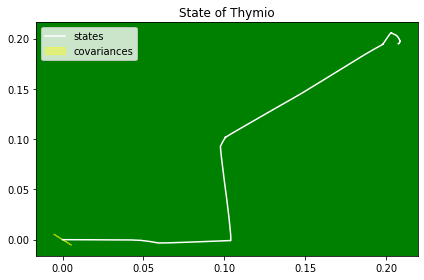

headto_theta: 2.5521649872495464
rotate to dt:-1.2331089165656923
move with 0, -100
thymio: (0.2076301396654204, 0.19489751921392512, 3.7852739038152383)


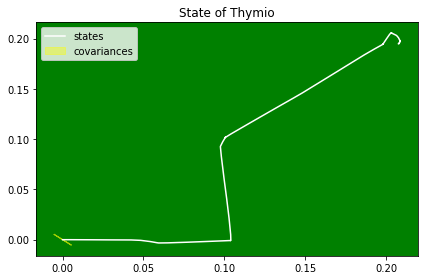

headto_theta: 2.605463191067363
rotate to dt:-0.9457245563935075
move with 0, -100
thymio: (0.20811398219159627, 0.19517883006522052, 3.551187747460871)


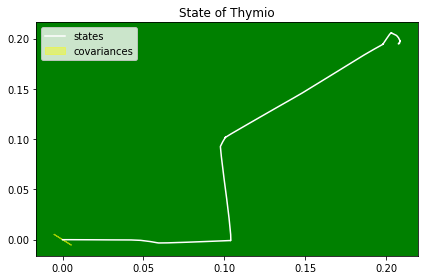

headto_theta: 2.6183662132527252
rotate to dt:-0.6920518347318483
move with 0, -79.20518347318482
thymio: (0.2082747625325797, 0.19522667072278943, 3.3104180479845735)


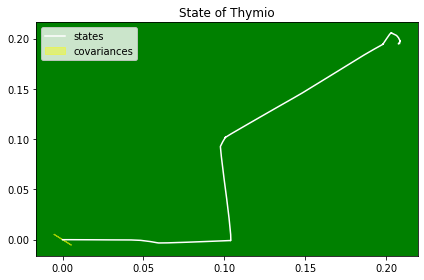

headto_theta: 2.623235324516057
rotate to dt:-0.47167998092802765
move with 0, -57.16799809280276
thymio: (0.2083595529450223, 0.19523185566267467, 3.0949153054440846)


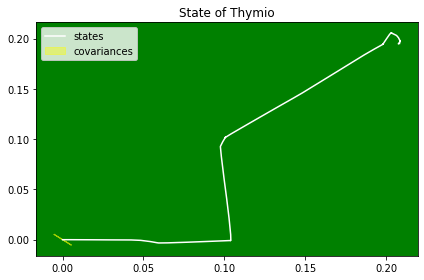

headto_theta: 2.623301378497427
rotate to dt:-0.29925150886450425
move with 0, -39.925150886450425
thymio: (0.20836122888719472, 0.19523163167999327, 2.9225528873619306)


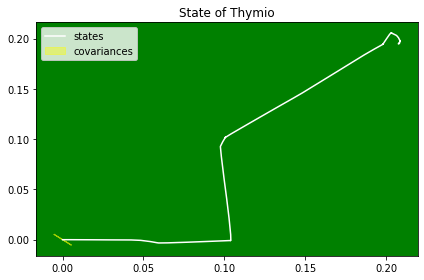

headto_theta: 2.622456197697881
rotate to dt:-0.18675507069097463
move with 0, -28.675507069097463
thymio: (0.20832875180217728, 0.1952408199641362, 2.809211268388856)


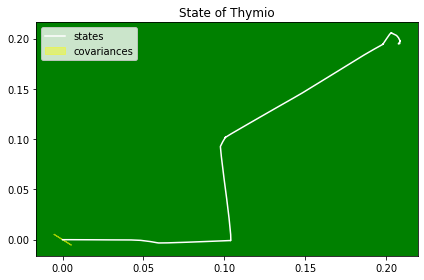

headto_theta: 2.6234957188523933
rotate to dt:-0.10386346484884967
move with 0, -20.386346484884967
thymio: (0.20839310340578945, 0.19521561517509925, 2.7273591837012434)


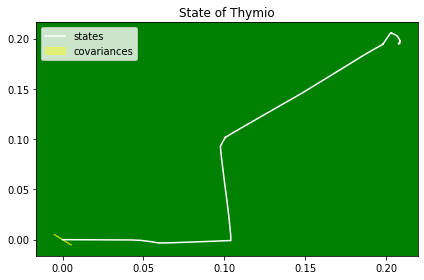

headto_theta: 2.623817057187178
approach to dr:0.009703731429964325, dt:0
move with 100, 0.0
thymio: (0.20843178857216466, 0.19519715239267463, 2.665248981990607)


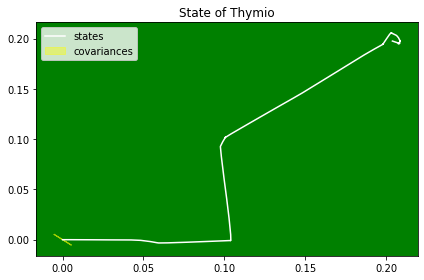

Close to the point
rotate to dt:-2.6258202348273714
move with 0, -100
thymio: (0.2039999401677956, 0.1975956467901285, 2.6258202348273714)


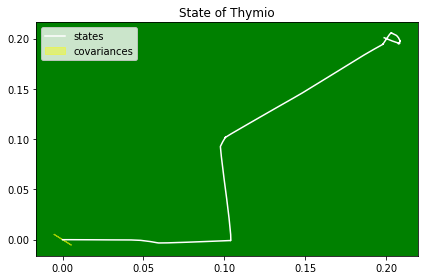

Close to the point
rotate to dt:-2.50342608728314
move with 0, -100
thymio: (0.19891180208077788, 0.20090723947620934, 2.50342608728314)


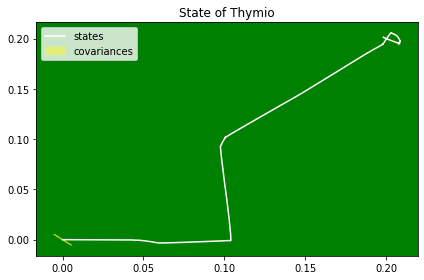

Close to the point
rotate to dt:-2.2817053237340765
move with 0, -100
thymio: (0.19840487183319172, 0.20137857337028484, 2.281705323734076)


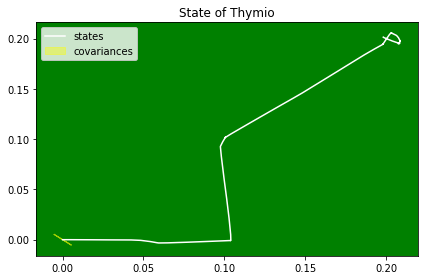

Close to the point
rotate to dt:-2.0325675425353342
move with 0, -100
thymio: (0.1983411428150509, 0.201474512093919, 2.032567542535334)


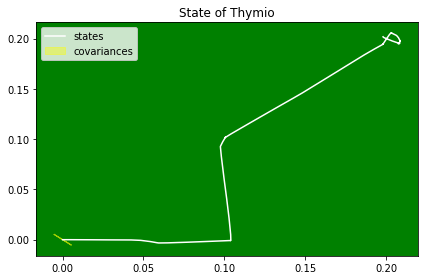

Close to the point
rotate to dt:-1.7874403152984097
move with 0, -100
thymio: (0.19821013025783965, 0.2018458149121032, 1.7874403152984102)


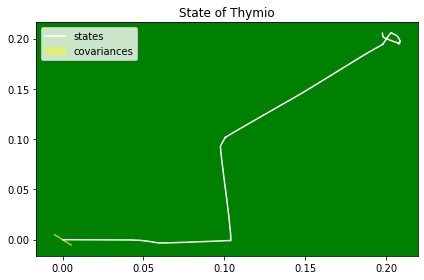

headto_theta: -1.1797149642889124
rotate to dt:-2.769234818053026
move with 0, -100
thymio: (0.19779652965381483, 0.20534408403666396, 1.5895198537641138)


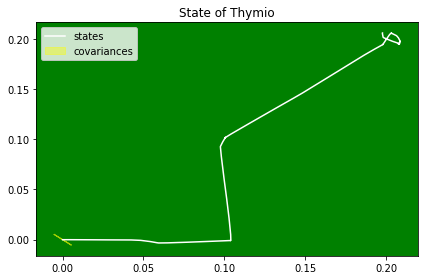

headto_theta: -1.216800693006064
rotate to dt:-2.570029587986019
move with 0, -100
thymio: (0.19784509509155856, 0.2058309514975812, 1.3532288949799547)


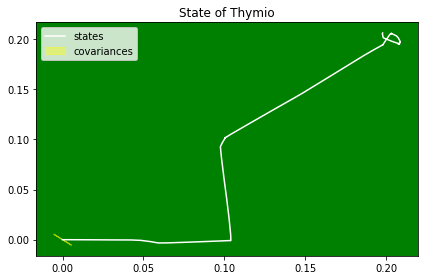

headto_theta: -1.2426385372315603
rotate to dt:-2.3555591481464164
move with 0, -100
thymio: (0.19793123511346802, 0.2060762420809628, 1.1129206109148564)


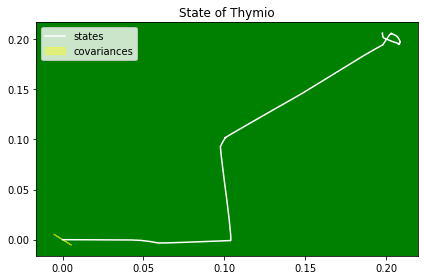

headto_theta: -1.2149858660080648
rotate to dt:-2.0952274198016445
move with 0, -100
thymio: (0.19781098186974483, 0.20589035965032107, 0.8802415537935795)


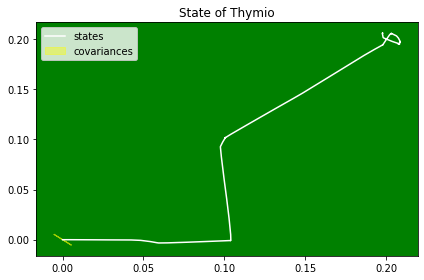

headto_theta: -1.2278505850830608
rotate to dt:-1.857476137719713
move with 0, -100
thymio: (0.19787523463538848, 0.20595081214313712, 0.6296255526366522)


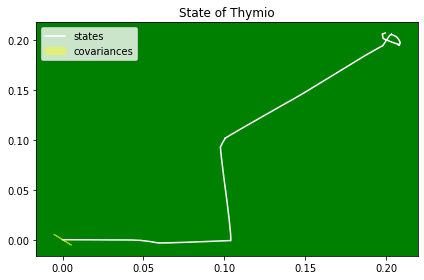

headto_theta: -1.5048719287655703
rotate to dt:-1.9473261835418452
move with 0, -100
thymio: (0.19954176589770065, 0.20694083057384446, 0.44245425477627515)


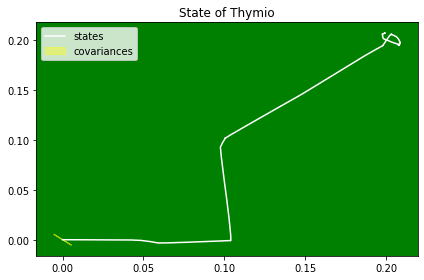

headto_theta: -1.4893125714967932
rotate to dt:-1.6942208904200546
move with 0, -100
thymio: (0.19943607559706214, 0.2069053735943426, 0.20490831892326145)


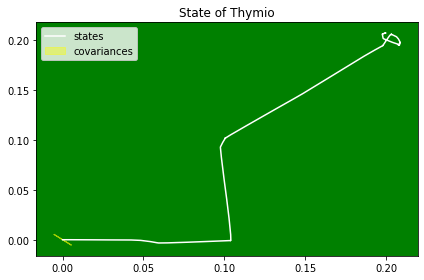

headto_theta: -1.54123084900494
rotate to dt:-1.5110785095427488
move with 0, -100
thymio: (0.1997948503372606, 0.20693680263665146, 6.253032967717395)


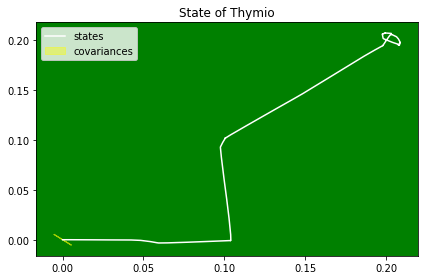

headto_theta: -2.0005735711246064
rotate to dt:-1.788266772380382
move with 0, -100
thymio: (0.20300049185975585, 0.2065462690459892, 6.070878508435363)


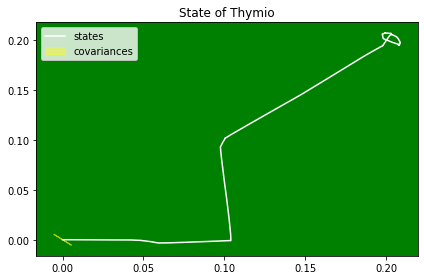

headto_theta: -2.007682256947732
rotate to dt:-1.5478993383009811
move with 0, -100
thymio: (0.20304906565410355, 0.2065293025584302, 5.823402388532835)


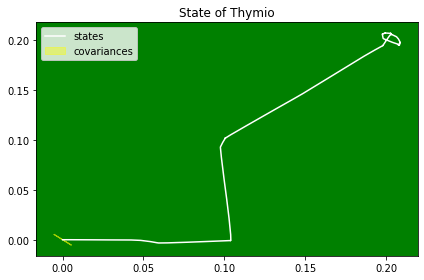

headto_theta: -1.9935212394631583
rotate to dt:-1.3011804936400075
move with 0, -100
thymio: (0.20296247495080205, 0.20658554792173944, 5.590844561356436)


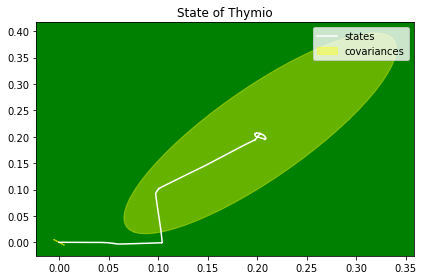

headto_theta: -2.0192579430568296
rotate to dt:-1.075225086181323
move with 0, -100
thymio: (0.20309870319071402, 0.20644007993479402, 5.33915245030408)


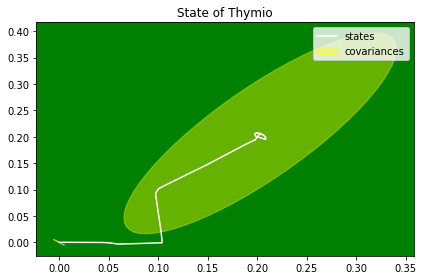

headto_theta: -2.0245991067032834
rotate to dt:-0.8195836669577385
move with 0, -91.95836669577385
thymio: (0.20312104680955534, 0.20639881534162838, 5.078169867434041)


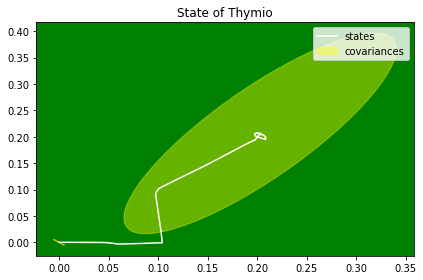

headto_theta: -2.37011090218095
rotate to dt:-0.9760992260185049
move with 0, -100
thymio: (0.2038573755340046, 0.20375148071943786, 4.889173631017141)


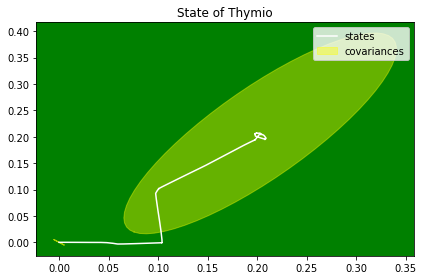

headto_theta: -2.3506398572517484
rotate to dt:-0.7012002924459093
move with 0, -80.12002924459092
thymio: (0.20385040490446946, 0.20389341944869815, 4.633745742373747)


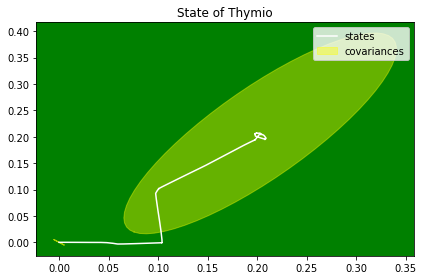

headto_theta: -2.330231915491849
rotate to dt:-0.4396341526488152
move with 0, -53.96341526488152
thymio: (0.20389202309385338, 0.2040995515789228, 4.3925875443365525)


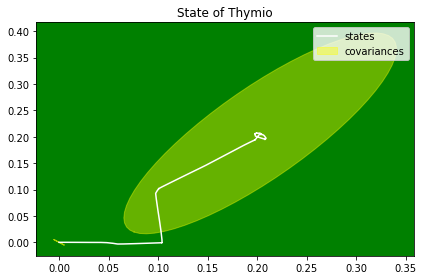

headto_theta: -2.3128368460937963
rotate to dt:-0.2540725951310634
move with 0, -35.40725951310634
thymio: (0.20400850140541024, 0.20437209205897433, 4.224421056216853)


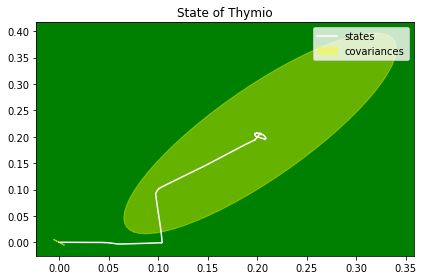

headto_theta: -2.309194808092923
rotate to dt:-0.13199897370713032
move with 0, -23.199897370713032
thymio: (0.20406764130805474, 0.2044691641446749, 4.105989472793794)


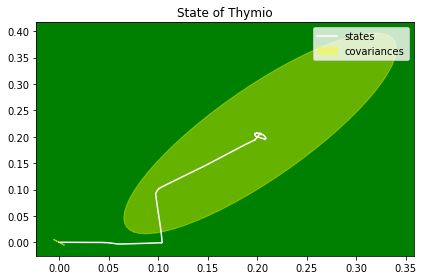

headto_theta: -2.307485660375017
approach to dr:0.006157217697591361, dt:0
move with 100, 0.0
thymio: (0.20413666142987416, 0.2045606317534004, 4.0259298692138)


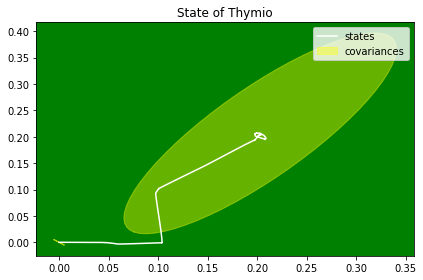

Close to the point
rotate to dt:2.328651523556778
move with 0, 100
thymio: (0.20105192956593484, 0.20105880294627707, 3.954533783622808)


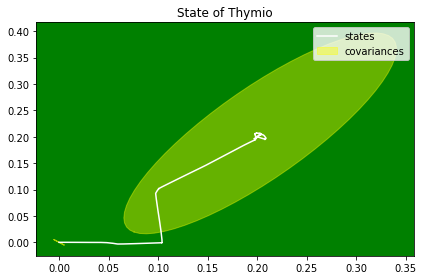

Close to the point
rotate to dt:2.235338349332184
move with 0, 100
thymio: (0.19706347420248654, 0.19642975677625615, 4.047846957847402)


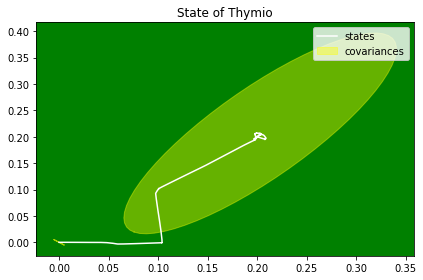

headto_theta: 0.8984749546721462
rotate to dt:2.887112924665093
move with 0, 100
thymio: (0.19677226840980325, 0.19594526234774592, 4.294547337186639)


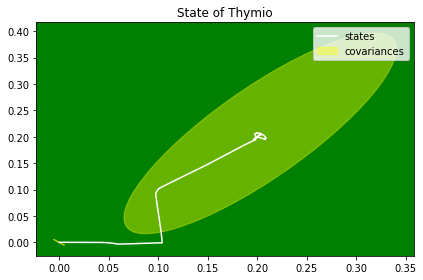

headto_theta: 0.9130623269457854
rotate to dt:2.6184130123793157
move with 0, 100
thymio: (0.19671690214035864, 0.19574992719446926, 4.577834621746056)


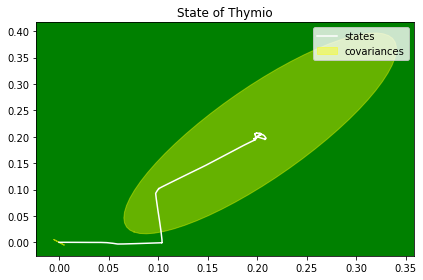

headto_theta: 0.888021797359652
rotate to dt:2.3151805875165854
move with 0, 100
thymio: (0.1967159396234275, 0.1959618596950905, 4.856026517022653)


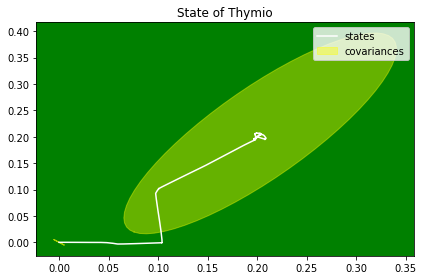

headto_theta: 0.9494059019707245
rotate to dt:2.1186907248087987
move with 0, 100
thymio: (0.1968262063753515, 0.19556739030575257, 5.113900484341512)


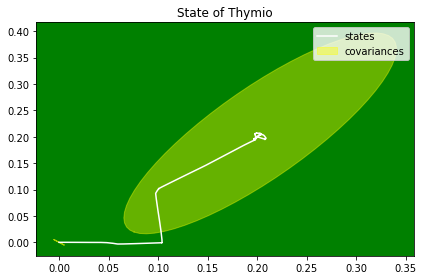

headto_theta: 0.9817704595755485
rotate to dt:1.8991245953796083
move with 0, 100
thymio: (0.19692502690459693, 0.19539775084027974, 5.365831171375526)


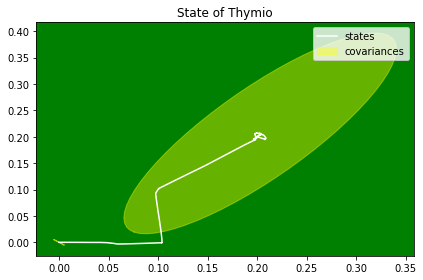

headto_theta: 0.8601531388507073
rotate to dt:1.4901439103749183
move with 0, 100
thymio: (0.19644371916407716, 0.19586790154391986, 5.653194535655375)


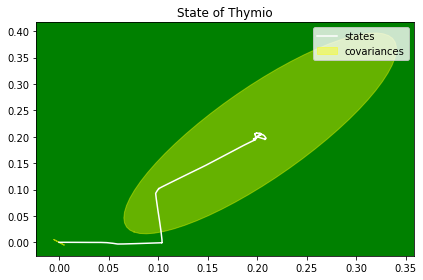

headto_theta: 0.8576232445958762
rotate to dt:1.2210008877727834
move with 0, 100
thymio: (0.1964313036260669, 0.19587463082610718, 5.919807664002679)


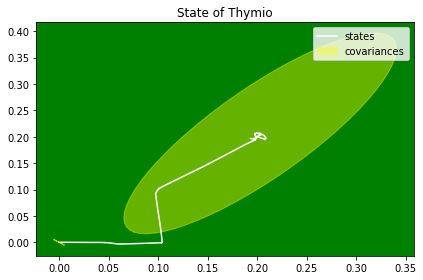

headto_theta: 0.45702425117836354
rotate to dt:0.6203464896968143
move with 0, 72.03464896968143
thymio: (0.19331783490848453, 0.19671405861379335, 6.119863068661136)


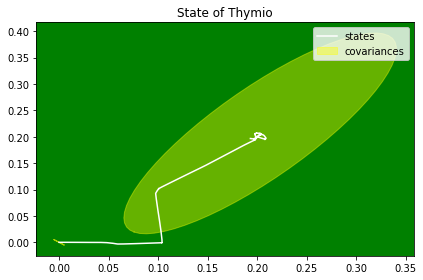

headto_theta: 0.4518959389352336
rotate to dt:0.39035591476026055
move with 0, 49.03559147602605
thymio: (0.1932386893958355, 0.19671808989737433, 0.06154002417497306)


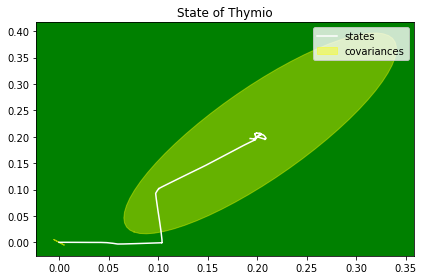

headto_theta: 0.44156084410140894
rotate to dt:0.22713551635967913
move with 0, 32.71355163596791
thymio: (0.19298132323459607, 0.1966823507220026, 0.21442532774172982)


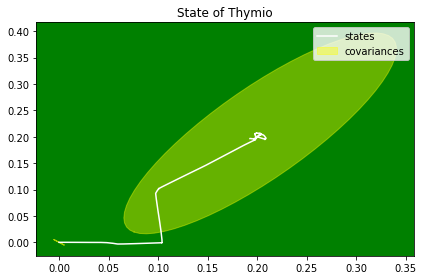

headto_theta: 0.4374334061823286
rotate to dt:0.12461496549874573
move with 0, 22.461496549874575
thymio: (0.19280244141123298, 0.19663406989273488, 0.3128184406835829)


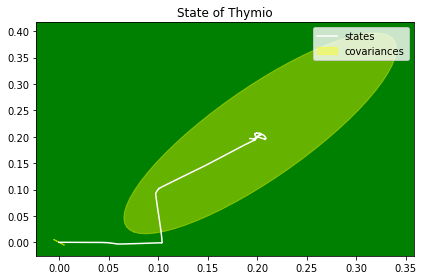

headto_theta: 0.4364174504527296
approach to dr:0.008036045829345969, dt:0
move with 100, 0.0
thymio: (0.19271715825637065, 0.1966032002254183, 0.38177276089212314)


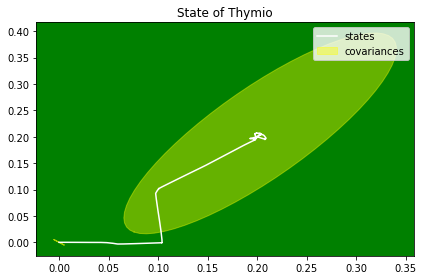

Close to the point
rotate to dt:-0.44885525371123336
move with 0, -54.885525371123336
thymio: (0.19786659365150852, 0.1988739144959601, 0.4488552537112333)


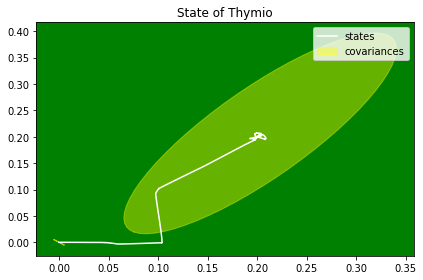

Close to the point
rotate to dt:-0.4145208693578182
move with 0, -51.452086935781814
thymio: (0.20436930812027224, 0.2018694921737032, 0.41452086935781784)


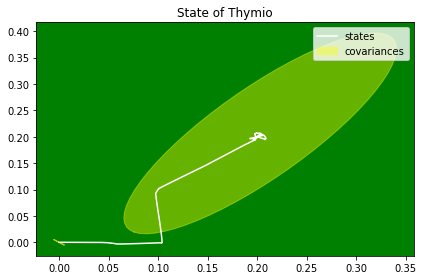

headto_theta: -2.743627033732311
rotate to dt:-3.0235624710328874
move with 0, -100
thymio: (0.20492731349988685, 0.20207142900739516, 0.2799354373005761)


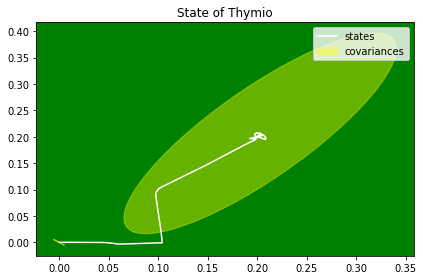

headto_theta: -2.750261418817405
rotate to dt:-2.837874074291295
move with 0, -100
thymio: (0.20509649637597477, 0.20210287523889423, 0.08761265547389016)


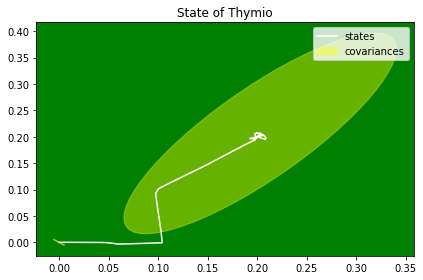

headto_theta: -2.7706772363289103
rotate to dt:-2.595386094986466
move with 0, -100
thymio: (0.20537553361473423, 0.20209063461492469, 6.107894165837141)


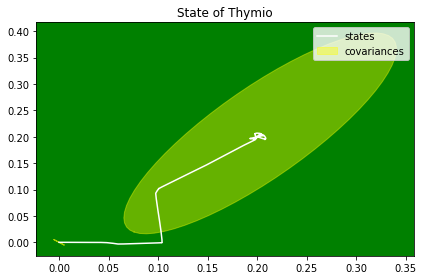

headto_theta: -2.8252889090335724
rotate to dt:-2.394234659053401
move with 0, -100
thymio: (0.20589304647987397, 0.20192874832921218, 5.852131057199415)


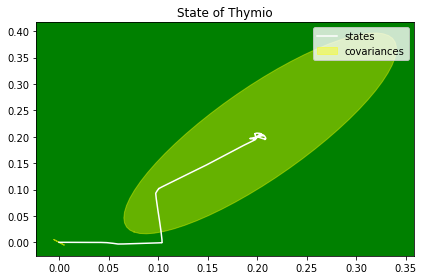

headto_theta: -2.8490852331423113
rotate to dt:-2.1627567049473058
move with 0, -100
thymio: (0.20605939435367107, 0.20182475960767304, 5.596856778984581)


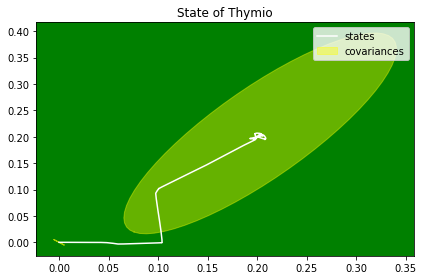

headto_theta: -2.7448660692295417
rotate to dt:-1.7795282175903555
move with 0, -100
thymio: (0.20558458609510719, 0.20233960641848717, 5.3178474555404)


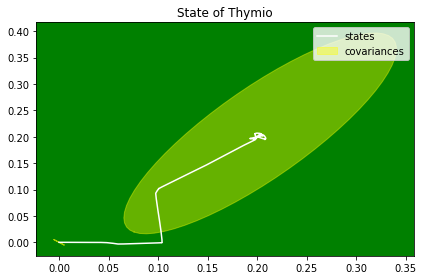

headto_theta: -2.6858021743584404
rotate to dt:-1.4609937297158604
move with 0, -100
thymio: (0.20542086373593504, 0.20265739858403775, 5.058376862537006)


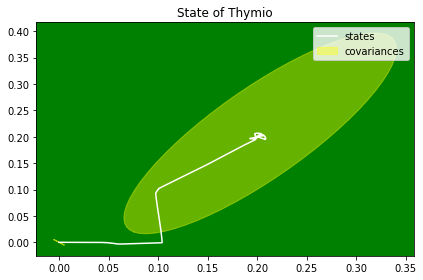

headto_theta: -2.573454008431507
rotate to dt:-1.087622861784781
move with 0, -100
thymio: (0.20526665609181668, 0.20336194675822244, 4.79735416053286)


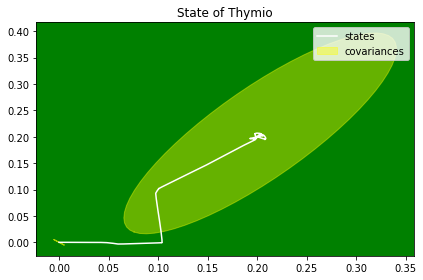

headto_theta: -2.5650793086126638
rotate to dt:-0.82824169841974
move with 0, -92.824169841974
thymio: (0.20526925621570932, 0.20342605194685573, 4.546347696986663)


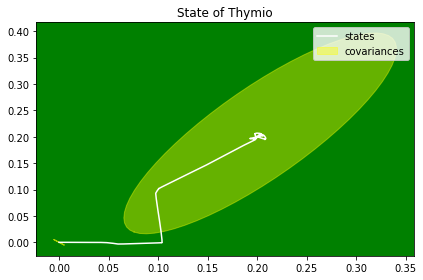

headto_theta: -2.574608407521981
rotate to dt:-0.5754031256587924
move with 0, -67.54031256587923
thymio: (0.2052422399422495, 0.20333784949577416, 4.2839800253163975)


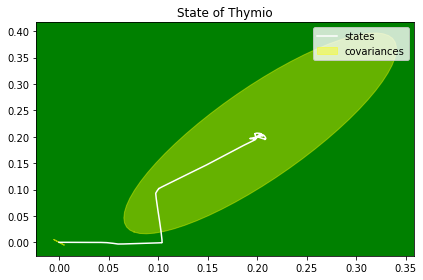

headto_theta: -2.6041340766176044
rotate to dt:-0.39344448417372746
move with 0, -49.344448417372746
thymio: (0.2050471234401589, 0.20300798600990777, 4.072495714735709)


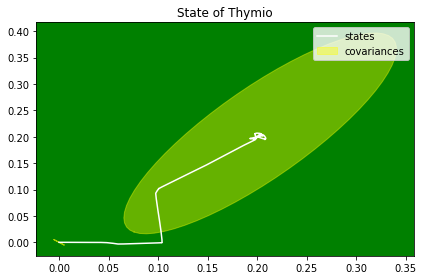

headto_theta: -2.5868648352200467
rotate to dt:-0.22527326732963537
move with 0, -32.52732673296354
thymio: (0.20527177839700883, 0.20326654766418625, 3.9215937392891744)


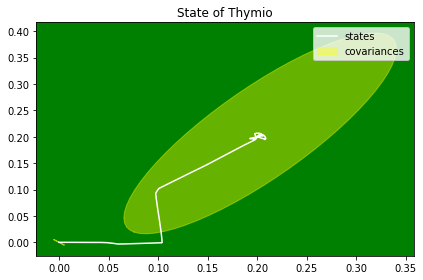

headto_theta: -2.5861561413249072
rotate to dt:-0.12150062271068052
move with 0, -22.15006227106805
thymio: (0.20529082720800765, 0.20328354233435367, 3.8185297885653595)


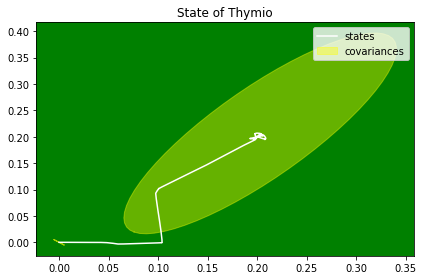

headto_theta: -2.5879436658564945
approach to dr:0.0060993717320227585, dt:0
move with 100, 0.0
thymio: (0.2051881961728099, 0.2032070166818773, 3.74606333549458)


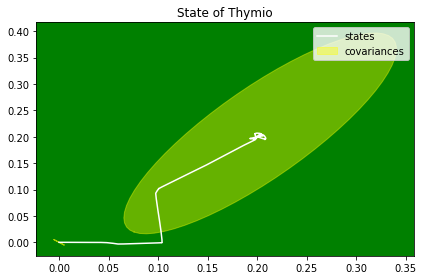

Close to the point
rotate to dt:2.5818483994669355
move with 0, 100
thymio: (0.20063675490153368, 0.200211327640018, 3.701336907712651)


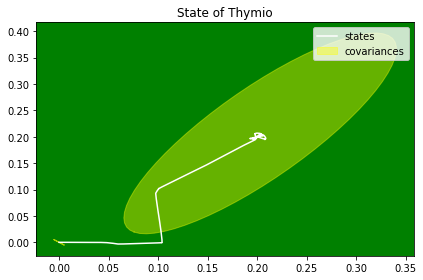

headto_theta: 0.6367525584635153
rotate to dt:3.1326250143234167
move with 0, 100
thymio: (0.1955823661167698, 0.19673312292904296, 3.787312851319685)


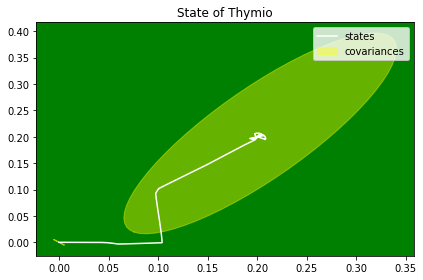

headto_theta: 0.6529599305540416
rotate to dt:2.9135337450841123
move with 0, 100
thymio: (0.1949984765507666, 0.19617440747553133, 4.022611492649515)


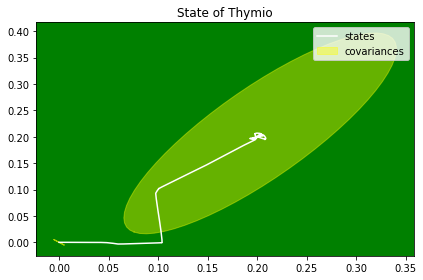

headto_theta: 0.6549967354601779
rotate to dt:2.6675680989685544
move with 0, 100
thymio: (0.1949784270775688, 0.19614283477407657, 4.27061394367121)


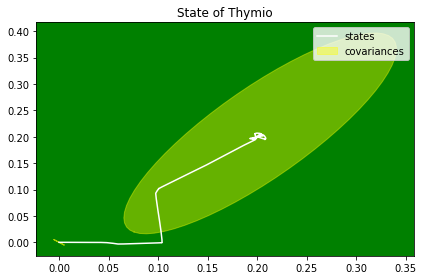

headto_theta: 0.6223854649622481
rotate to dt:2.3596501632676783
move with 0, 100
thymio: (0.19508136011488547, 0.19647079515551977, 4.545920608874156)


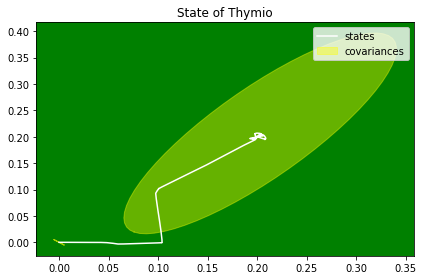

headto_theta: 0.5916355864275005
rotate to dt:2.052634482997636
move with 0, 100
thymio: (0.19508783908080254, 0.1966993860944538, 4.822186410609451)


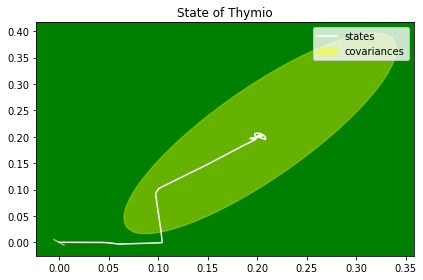

headto_theta: 0.623364626814487
rotate to dt:1.8035851065380601
move with 0, 100
thymio: (0.19513775699880584, 0.1965040437847463, 5.102964827456013)


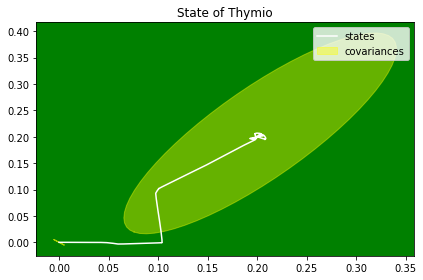

headto_theta: 0.588802578654932
rotate to dt:1.5064400153356097
move with 0, 100
thymio: (0.19503436768973678, 0.19668383751139742, 5.365547870498909)


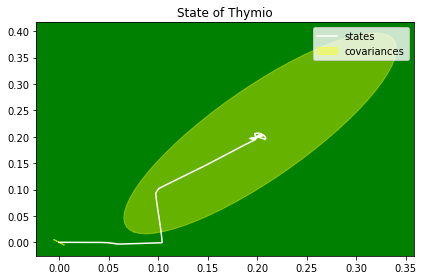

headto_theta: 0.5316698327116577
rotate to dt:1.1838224746784167
move with 0, 100
thymio: (0.19478513909981235, 0.19693281544160673, 5.631032665212827)


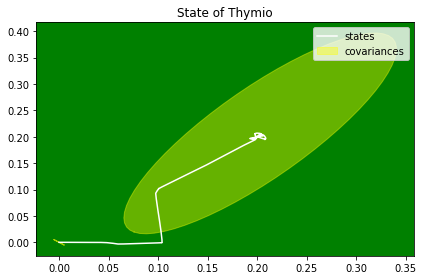

headto_theta: 0.5321171905667647
rotate to dt:0.9141286200794037
move with 0, 100
thymio: (0.19478785260595008, 0.19693127228768018, 5.901173877666947)


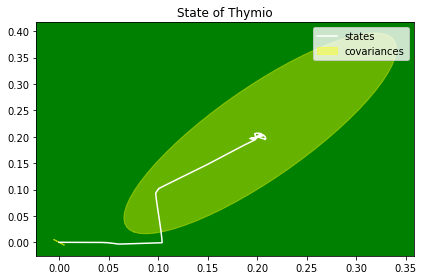

headto_theta: 0.5259813801705391
rotate to dt:0.6479880302471228
move with 0, 74.79880302471227
thymio: (0.1947366456287763, 0.19694445721637807, 6.161178657103003)


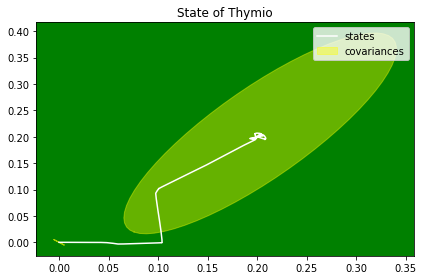

headto_theta: 0.54611454100337
rotate to dt:0.44356010301792603
move with 0, 54.3560103017926
thymio: (0.1949688342530491, 0.19694219885398384, 0.10255443798544395)


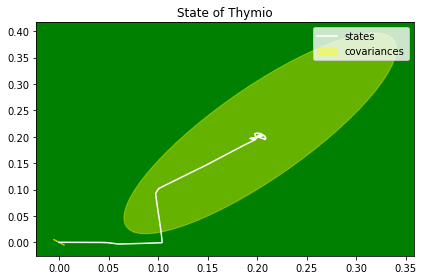

headto_theta: 0.5418559832868778
rotate to dt:0.2867057306150568
move with 0, 38.67057306150568
thymio: (0.1948993512425122, 0.19692963742912303, 0.255150252671821)


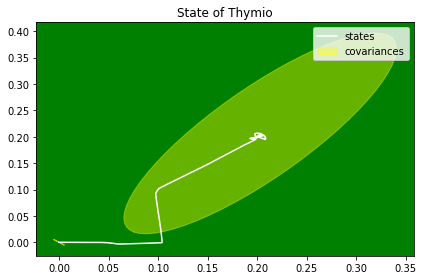

headto_theta: 0.529594805837762
rotate to dt:0.1600074128585608
move with 0, 26.00074128585608
thymio: (0.19457705263106478, 0.19682555387063372, 0.3695873929792012)


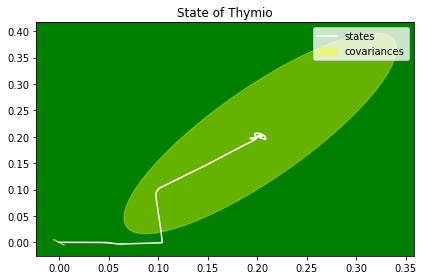

headto_theta: 0.527248336625061
approach to dr:0.006416038117533468, dt:0
move with 100, 0.0
thymio: (0.19445529283787918, 0.19677172373983137, 0.4629441319493188)


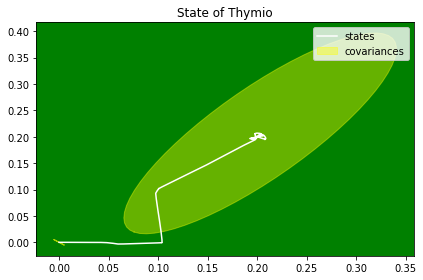

Close to the point
rotate to dt:-0.5295969020148856
move with 0, -62.95969020148856
thymio: (0.19845063320723763, 0.19893507981020794, 0.5295969020148856)


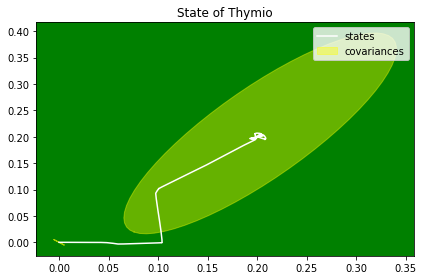

Close to the point
rotate to dt:-0.4898420888576469
move with 0, -58.98420888576469
thymio: (0.204395235792621, 0.20225805620529835, 0.48984208885764663)


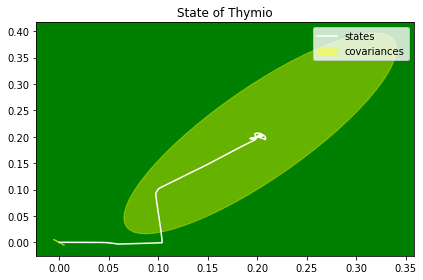

headto_theta: -2.6738865514647943
rotate to dt:-3.0003439487183083
move with 0, -100
thymio: (0.20491960142489235, 0.2024848093090595, 0.32645739725351386)


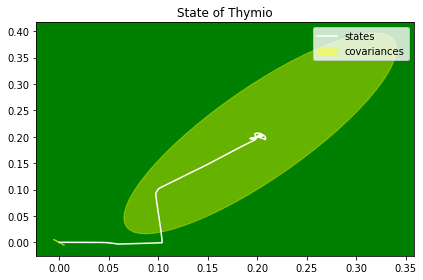

headto_theta: -2.674486798307044
rotate to dt:-2.7774130779592556
move with 0, -100
thymio: (0.20493254403534203, 0.2024876314760425, 0.1029262796522118)


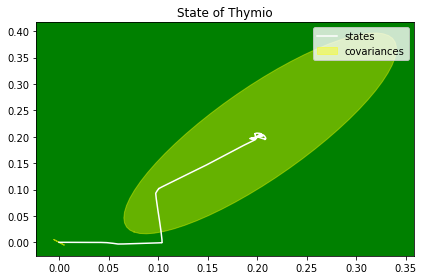

headto_theta: -2.6888799759199715
rotate to dt:-2.5264118139768286
move with 0, -100
thymio: (0.20510383302830099, 0.20248253053442183, 6.120717145236442)


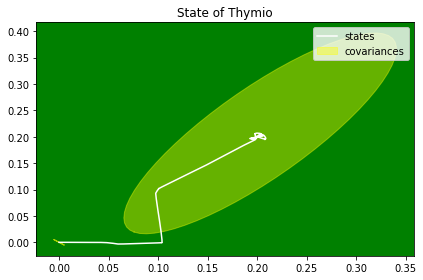

headto_theta: -2.6929528593660317
rotate to dt:-2.2552156422878458
move with 0, -100
thymio: (0.20513627336530393, 0.20247249191207217, 5.8454480901014)


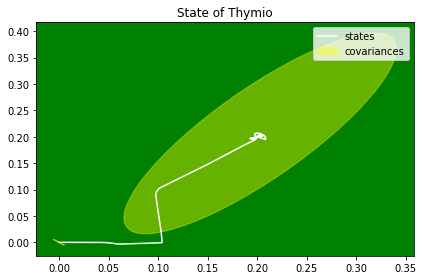

headto_theta: -2.7279652569943034
rotate to dt:-2.022034165834757
move with 0, -100
thymio: (0.20533758451433856, 0.20234293624998917, 5.577254216020039)


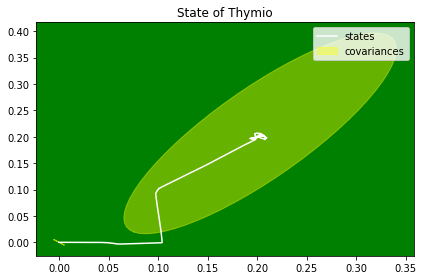

headto_theta: 2.9551710026071456
rotate to dt:-2.493265539618619
move with 0, -100
thymio: (0.20962260003156877, 0.19818506531410107, 5.448436542225765)


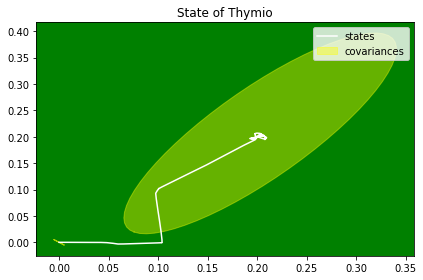

headto_theta: 2.9793547195913304
rotate to dt:-2.1995183824226663
move with 0, -100
thymio: (0.20943718223607863, 0.19845535493398392, 5.178873102013997)


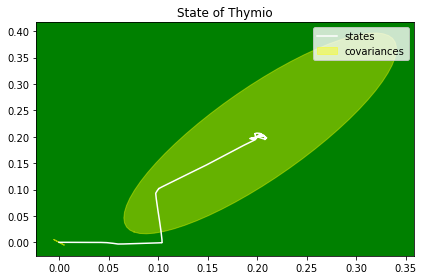

headto_theta: 2.94150611875039
rotate to dt:-1.9650423161014992
move with 0, -100
thymio: (0.20957324209544717, 0.1980585452799395, 4.906548434851889)


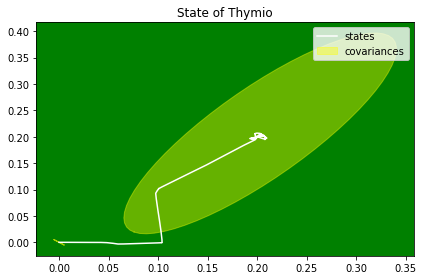

headto_theta: 2.8947486482892
rotate to dt:-1.7303166016186102
move with 0, -100
thymio: (0.20959876103386738, 0.19758127680909246, 4.62506524990781)


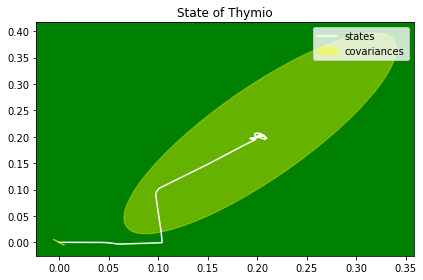

headto_theta: 2.844359821195283
rotate to dt:-1.5192829085888881
move with 0, -100
thymio: (0.20949057365725468, 0.19709297199267875, 4.363642729784171)


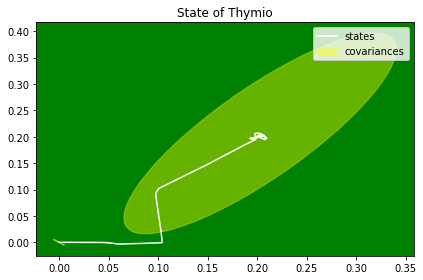

headto_theta: 2.7836928509211307
rotate to dt:-1.3031174081312127
move with 0, -100
thymio: (0.20920648885270127, 0.19655670880944554, 4.086810259052344)


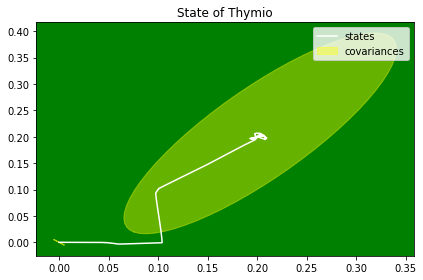

headto_theta: 2.783800433627032
rotate to dt:-1.0029968139049634
move with 0, -100
thymio: (0.20920729889491052, 0.19655753490751043, 3.7867972475319953)


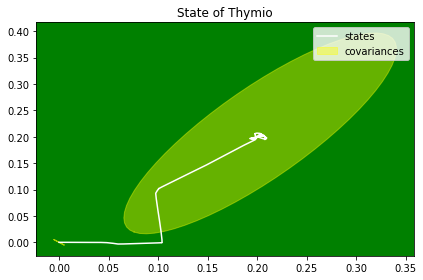

headto_theta: 2.763064782671641
rotate to dt:-0.739948210198313
move with 0, -83.99482101983129
thymio: (0.2089760054326074, 0.19643018209889554, 3.503012992869954)


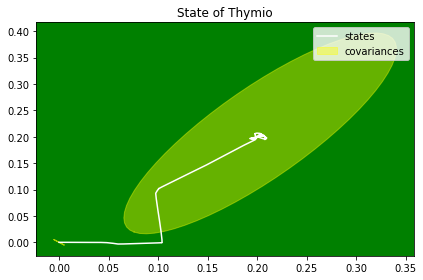

headto_theta: 2.7475950455507983
rotate to dt:-0.4536733738787895
move with 0, -55.36733738787895
thymio: (0.2087189116150587, 0.19637523717495212, 3.2012684194295873)


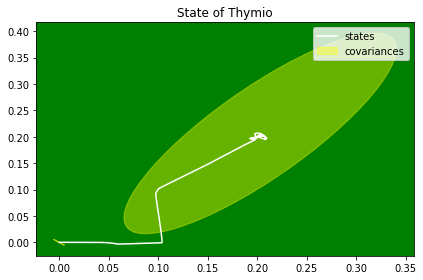

headto_theta: 2.7555584397647075
rotate to dt:-0.23060960481809722
move with 0, -33.06096048180972
thymio: (0.2089453049219714, 0.19636439043830375, 2.9861680445828047)


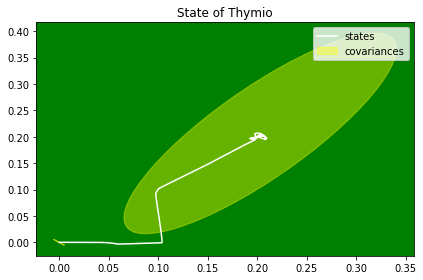

headto_theta: 2.7555584397647075
rotate to dt:-0.1112771783210178
move with 0, -21.12771783210178
thymio: (0.2089453049219714, 0.19636439043830375, 2.866835618085725)


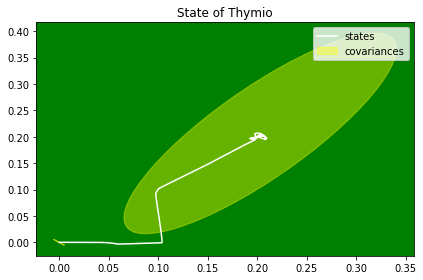

headto_theta: 2.7555584397647075
approach to dr:0.009655886133967331, dt:0
move with 100, 0.0
thymio: (0.2089453049219714, 0.19636439043830375, 2.7636151541292806)


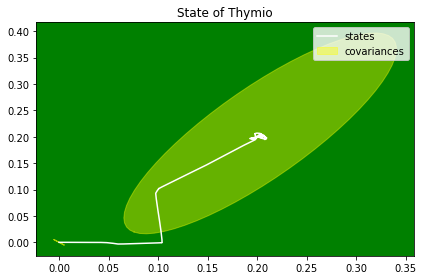

Close to the point
rotate to dt:-2.705105330362554
move with 0, -100
thymio: (0.2042458435334006, 0.19839147844271499, 2.705105330362554)


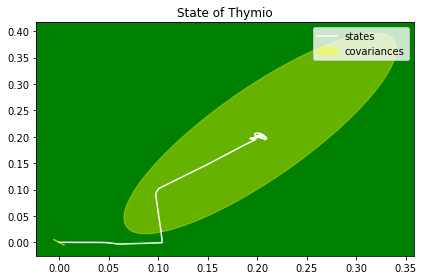

Close to the point
rotate to dt:-2.5829651315901603
move with 0, -100
thymio: (0.1986991865732736, 0.20140406282579199, 2.5829651315901603)


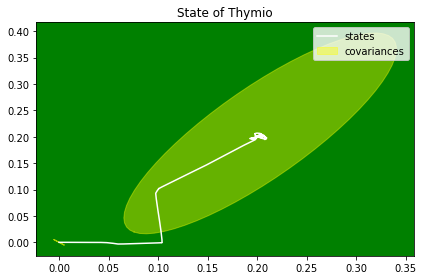

Close to the point
rotate to dt:-2.3321300866043244
move with 0, -100
thymio: (0.19859509196162908, 0.20148893882417315, 2.3321300866043244)


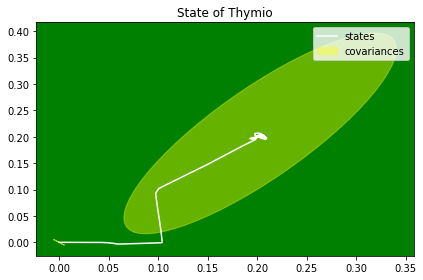

Close to the point
rotate to dt:-2.0751166949660593
move with 0, -100
thymio: (0.19840998982564467, 0.20174130942557614, 2.0751166949660593)


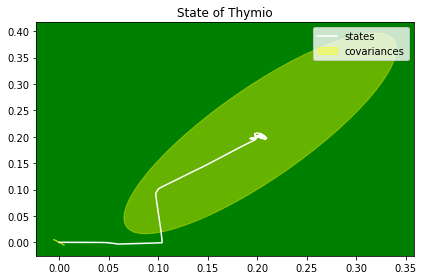

Close to the point
rotate to dt:-1.7020157248737302
move with 0, -100
thymio: (0.1982717329229611, 0.20216165023407034, 1.7020157248737302)


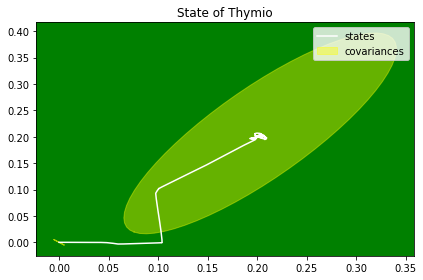

Close to the point
rotate to dt:-1.4004724341197639
move with 0, -100
thymio: (0.19827769037094484, 0.20246630517808842, 1.4004724341197639)


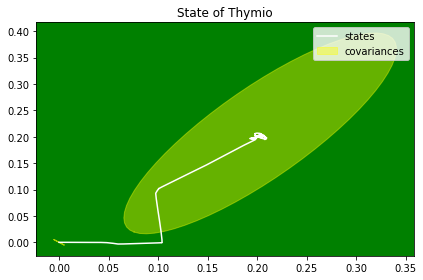

Close to the point
rotate to dt:-1.124794612645596
move with 0, -100
thymio: (0.19825299361985924, 0.2023887163637503, 1.1247946126455959)


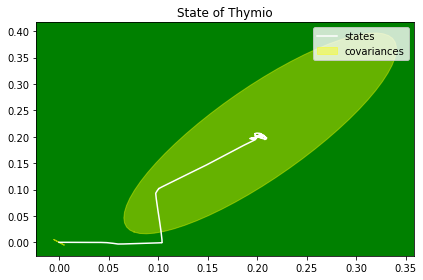

Close to the point
rotate to dt:-0.850887431169669
move with 0, -95.0887431169669
thymio: (0.19850243772124107, 0.20276700557767782, 0.8508874311696695)


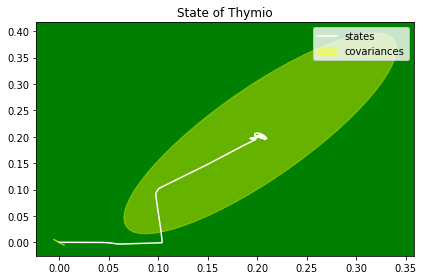

Close to the point
rotate to dt:-0.5876264014956583
move with 0, -68.76264014956583
thymio: (0.19821766002768804, 0.20251761035733576, 0.5876264014956579)


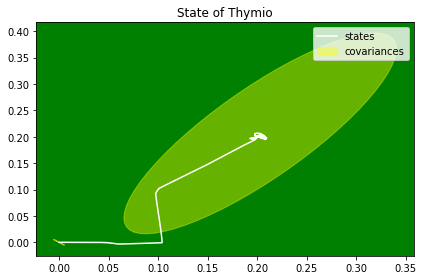

Close to the point
rotate to dt:-0.38552228473640415
move with 0, -48.55222847364041
thymio: (0.1983667389750212, 0.20259647250757526, 0.385522284736404)


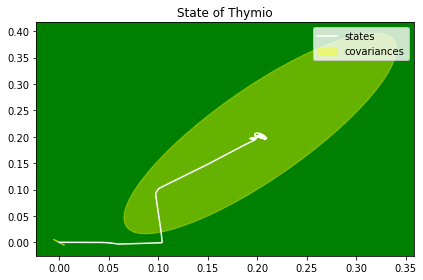

Close to the point
rotate to dt:-0.24168987755354365
move with 0, -34.168987755354365
thymio: (0.1985429669647523, 0.20265362469335405, 0.24168987755354385)


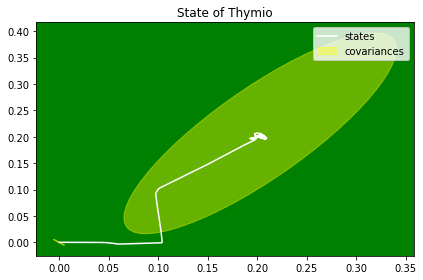

Close to the point
rotate to dt:-0.13708154189651633
move with 0, -23.708154189651633
thymio: (0.19853803761149, 0.20265267982061702, 0.13708154189651667)


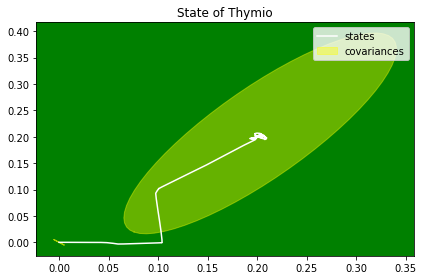

Terminate Reached!


In [30]:
debug_timer = 0.0
while True:
    starter = time.time()
    # 3. Localization
    Thymio_state = localizate()
    # 2.2.1 Finished?
    if Thymio_state.dis(Goal_state) < S_epsilon_dis \
        and abs(Thymio_state.ori - Goal_state.ori) < S_epsilon_theta:
        G_mc.stop()
        if G_verbose:
            print("Terminate Reached!")
        break
    # 2.2.2 Is there obstacles on the front?
    if G_mc.obs_front():
        G_mc.avoid() # do local navigation for, like, 10ms
    #     # TODO: replan
    elif starter - G_track_timer > S_track_interval:
        # 4. Follow the path    # <-- The only task can run under low frequency
        reached = G_mc.path_tracking(Global_path[0], Thymio_state, len(Global_path) == 1)
        if reached:
            print(Global_path[0],"reached")
            G_mc.stop()
            Global_path = Global_path[1:]
            # assume Global_path is not empty because of 2.2.1
        G_track_timer = starter
    #loop_time = time.time() - starter
    time.sleep(0.2)
    if starter - debug_timer > S_track_interval:
        debug_timer = starter
        print(F"thymio: {Thymio_state}")

In [28]:
motors(0,0)